In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
class CrowdDataset(Dataset):
    def __init__(self, image_paths, ground_truth_paths, transform=None, augment=False, patch_size=256):
        self.image_paths = image_paths
        self.ground_truth_paths = ground_truth_paths
        self.transform = transform
        self.augment = augment
        self.patch_size = patch_size
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        gt_path = self.ground_truth_paths[idx]
        try:
            mat_data = scipy.io.loadmat(gt_path)
            points = mat_data['image_info'][0, 0][0, 0][0]
            if points.size > 0 and len(points.shape) == 2 and points.shape[1] == 2:
                points = points.tolist()
            else:
                points = []
        except Exception as e:
            print(f"Error loading ground truth file {gt_path}: {e}")
            points = []
        
        density_map = self.generate_density_map(img.shape[:2], points)
        
        if self.augment:
            img, density_map = self.apply_augmentation(img, density_map)
        
        img = cv2.resize(img, (self.patch_size, self.patch_size))
        density_map = cv2.resize(density_map, (self.patch_size, self.patch_size))
        
        img = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)
        
        if self.transform:
            img = self.transform(img)
            
        return img, density_map
    
    def generate_density_map(self, img_shape, points):
        h, w = img_shape
        density_map = np.zeros((h, w), dtype=np.float32)
        
        if len(points) == 0:
            return density_map
        
        points = np.array(points)
        
        for i, point in enumerate(points):
            x, y = int(point[0]), int(point[1])
            
            if x < 0 or x >= w or y < 0 or y >= h:
                continue
            
            if len(points) > 1:
                distances = np.sqrt(np.sum((points - point) ** 2, axis=1))
                distances = np.sort(distances)[1:]  # Exclude self (distance=0)
                
                k = min(3, len(distances))
                avg_distance = np.mean(distances[:k])
                
                sigma = max(1.0, avg_distance / 3.0)
            else:
                sigma = 4.0  
            
            kernel_size = int(6 * sigma)
            if kernel_size % 2 == 0:
                kernel_size += 1
            
            gaussian = self.gaussian_2d(kernel_size, sigma)
            
            x_start = max(0, x - kernel_size // 2)
            x_end = min(w, x + kernel_size // 2 + 1)
            y_start = max(0, y - kernel_size // 2)
            y_end = min(h, y + kernel_size // 2 + 1)
            
            g_x_start = max(0, kernel_size // 2 - x)
            g_x_end = g_x_start + (x_end - x_start)
            g_y_start = max(0, kernel_size // 2 - y)
            g_y_end = g_y_start + (y_end - y_start)
            
            density_map[y_start:y_end, x_start:x_end] += gaussian[g_y_start:g_y_end, g_x_start:g_x_end]
        
        return density_map
    
    def gaussian_2d(self, kernel_size, sigma):
        kernel = np.zeros((kernel_size, kernel_size))
        center = kernel_size // 2
        
        for i in range(kernel_size):
            for j in range(kernel_size):
                x, y = i - center, j - center
                kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))
        
        return kernel / np.sum(kernel)
    
    def apply_augmentation(self, img, density_map):
        if random.random() > 0.5:
            img = cv2.flip(img, 1)
            density_map = cv2.flip(density_map, 1)
        
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.8, 1.2)
            img = np.clip(img * brightness_factor, 0, 255).astype(np.uint8)
        
        if random.random() > 0.7:
            noise = np.random.normal(0, 5, img.shape).astype(np.uint8)
            img = np.clip(img + noise, 0, 255).astype(np.uint8)
        
        return img, density_map

In [ ]:
class PReLU(nn.Module):
    def __init__(self, num_parameters=1):
        super(PReLU, self).__init__()
        self.num_parameters = num_parameters
        self.weight = nn.Parameter(torch.Tensor(num_parameters).fill_(0.25))
    
    def forward(self, x):
        return F.prelu(x, self.weight)


In [ ]:
class CascadedCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(CascadedCNN, self).__init__()

        self.shared_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=9, padding=4),
            nn.BatchNorm2d(32), 
            PReLU(32),
            nn.Conv2d(32, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32), 
            PReLU(32),
            nn.Conv2d(32, 64, kernel_size=7, padding=3),
            nn.BatchNorm2d(64), 
            PReLU(64),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64), 
            PReLU(64),
            nn.Conv2d(64, 64, kernel_size=5, padding=2),
            nn.BatchNorm2d(64), 
            PReLU(64),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(0.25), 

            # Second block
            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm2d(128), 
            PReLU(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            PReLU(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            PReLU(128),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(0.25), 
        )

        # High-level prior branch (crowd classification) 
        self.high_level_conv = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            PReLU(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            PReLU(256),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(0.25), 

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            PReLU(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            PReLU(256),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(0.25), 

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            PReLU(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            PReLU(512),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout2d(0.25), 

            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            PReLU(512),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512), 
            PReLU(512),
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 1024),
            PReLU(),
            nn.Dropout(0.5), 
            nn.Linear(1024, 512),
            PReLU(),
            nn.Dropout(0.5), 
            nn.Linear(512, num_classes),
            nn.Sigmoid()
        )

        self.density_conv = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            PReLU(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            PReLU(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256), 
            PReLU(256),
            nn.Dropout2d(0.25), 

            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            PReLU(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            PReLU(128),
            nn.Dropout2d(0.25), 

            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            PReLU(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            PReLU(64),
            nn.Dropout2d(0.25), 

            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), 
            PReLU(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), 
            PReLU(32),
            nn.Dropout2d(0.25), 

            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16), 
            PReLU(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16), 
            PReLU(16),
        )

        # Fusion layers 
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(16 + 512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            PReLU(128),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128), 
            PReLU(128),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            PReLU(64),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            PReLU(64),
        )

        # Upsampling layers 
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(32), 
            PReLU(32),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), 
            PReLU(32),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), 
            nn.BatchNorm2d(16), 
            PReLU(16),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16), 
            PReLU(16),
            nn.Conv2d(16, 1, kernel_size=1), 
        )

    def forward(self, x):
        shared_features = self.shared_conv(x)

        high_level_features = self.high_level_conv(shared_features)

        pooled_features = self.adaptive_pool(high_level_features)
        flattened = pooled_features.view(pooled_features.size(0), -1)
        classification = self.classifier(flattened)

        density_features = self.density_conv(shared_features)

        interpolated_high_level_features = F.interpolate(
            high_level_features,
            size=density_features.shape[2:],
            mode='bilinear',
            align_corners=False
        )

        fused_features = torch.cat([density_features, interpolated_high_level_features], dim=1)
        fused_features = self.fusion_conv(fused_features)

        density_map = self.upsample(fused_features)

        return density_map, classification

In [ ]:
class CrowdCountingTrainer:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.density_criterion = nn.MSELoss()
        self.classification_criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=0.5)

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_maes = []
        self.val_maes = []
        self.val_accuracies = [] # Added for classification accuracy

    def get_count_class(self, count):
        """Convert count to classification class (0-9)"""
        if count < 10:
            return 0
        elif count < 25:
            return 1
        elif count < 50:
            return 2
        elif count < 100:
            return 3
        elif count < 200:
            return 4
        elif count < 300:
            return 5
        elif count < 500:
            return 6
        elif count < 750:
            return 7
        elif count < 1000:
            return 8
        else:
            return 9

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        total_mae = 0

        for batch_idx, (images, density_maps) in enumerate(tqdm(train_loader, desc="Training")):
            images = images.to(self.device)
            density_maps = density_maps.to(self.device)

            # Get ground truth counts and classification labels
            gt_counts = torch.sum(density_maps, dim=(1, 2, 3))
            class_labels = torch.tensor([self.get_count_class(count.item()) for count in gt_counts],
                                      dtype=torch.long).to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            pred_density, pred_class = self.model(images)
            pred_counts = torch.sum(pred_density, dim=(1, 2, 3))

            # Calculate losses
            density_loss = self.density_criterion(pred_density, density_maps)
            class_loss = self.classification_criterion(pred_class, class_labels)

            # Combined loss
            total_loss_batch = density_loss + 0.1 * class_loss

            # Backward pass
            total_loss_batch.backward()
            self.optimizer.step()

            # Calculate MAE
            mae = torch.mean(torch.abs(pred_counts - gt_counts))

            total_loss += total_loss_batch.item()
            total_mae += mae.item()

        avg_loss = total_loss / len(train_loader)
        avg_mae = total_mae / len(train_loader)

        return avg_loss, avg_mae

    def validate_epoch(self, val_loader):
        self.model.eval()
        total_loss = 0
        total_mae = 0
        correct_predictions = 0
        total_samples = 0

        with torch.no_grad():
            for images, density_maps in tqdm(val_loader, desc="Validation"):
                images = images.to(self.device)
                density_maps = density_maps.to(self.device)

                # Get ground truth counts and classification labels
                gt_counts = torch.sum(density_maps, dim=(1, 2, 3))
                class_labels = torch.tensor([self.get_count_class(count.item()) for count in gt_counts],
                                          dtype=torch.long).to(self.device)

                # Forward pass
                pred_density, pred_class = self.model(images)
                pred_counts = torch.sum(pred_density, dim=(1, 2, 3))

                # Calculate losses
                density_loss = self.density_criterion(pred_density, density_maps)
                class_loss = self.classification_criterion(pred_class, class_labels)
                total_loss_batch = density_loss + 0.1 * class_loss

                # Calculate MAE
                mae = torch.mean(torch.abs(pred_counts - gt_counts))

                total_loss += total_loss_batch.item()
                total_mae += mae.item()

                # Calculate accuracy for classification
                predicted_classes = pred_class.argmax(dim=1)
                correct_predictions += (predicted_classes == class_labels).sum().item()
                total_samples += class_labels.size(0)


        avg_loss = total_loss / len(val_loader)
        avg_mae = total_mae / len(val_loader)
        accuracy = correct_predictions / total_samples # Calculate accuracy

        return avg_loss, avg_mae, accuracy

    def train(self, train_loader, val_loader, epochs=100, save_path='best_model.pth'):
        best_val_mae = float('inf')

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            # Training
            train_loss, train_mae = self.train_epoch(train_loader)

            # Validation
            val_loss, val_mae, val_accuracy = self.validate_epoch(val_loader) # Get accuracy from validation

            # Update learning rate
            self.scheduler.step()

            # Save best model
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_mae': val_mae,
                    'val_accuracy': val_accuracy # Save validation accuracy
                }, save_path)
                print(f"New best model saved with MAE: {val_mae:.4f} and Accuracy: {val_accuracy:.4f}") # Report accuracy

            # Store history
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_maes.append(train_mae)
            self.val_maes.append(val_mae)
            self.val_accuracies.append(val_accuracy) # Store validation accuracy

            print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Val Accuracy: {val_accuracy:.4f}") # Report accuracy
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")


    def test(self, test_loader, model_path='best_model.pth'):
        """Test the model on test dataset"""
        # Load best model
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])

        self.model.eval()
        total_mae = 0
        total_mse = 0
        correct_predictions = 0
        total_samples = 0
        all_predictions = []
        all_ground_truths = []


        with torch.no_grad():
            for images, density_maps in tqdm(test_loader, desc="Testing"):
                images = images.to(self.device)
                density_maps = density_maps.to(self.device)

                # Get ground truth counts and classification labels
                gt_counts = torch.sum(density_maps, dim=(1, 2, 3))
                class_labels = torch.tensor([self.get_count_class(count.item()) for count in gt_counts],
                                          dtype=torch.long).to(self.device)


                # Forward pass
                pred_density, pred_class = self.model(images) # Get classification predictions

                # Calculate counts
                pred_counts = torch.sum(pred_density, dim=(1, 2, 3))

                # Store predictions
                all_predictions.extend(pred_counts.cpu().numpy())
                all_ground_truths.extend(gt_counts.cpu().numpy())


                # Calculate errors
                mae = torch.mean(torch.abs(pred_counts - gt_counts))
                mse = torch.mean((pred_counts - gt_counts) ** 2)

                total_mae += mae.item()
                total_mse += mse.item()

                # Calculate accuracy for classification
                predicted_classes = pred_class.argmax(dim=1)
                correct_predictions += (predicted_classes == class_labels).sum().item()
                total_samples += class_labels.size(0)

        avg_mae = total_mae / len(test_loader)
        avg_mse = total_mse / len(test_loader)
        test_accuracy = correct_predictions / total_samples # Calculate test accuracy

        print(f"\nTest Results:")
        print(f"MAE: {avg_mae:.4f}")
        print(f"MSE: {avg_mse:.4f}")
        print(f"RMSE: {np.sqrt(avg_mse):.4f}")
        print(f"Accuracy: {test_accuracy:.4f}") # Report test accuracy

        return avg_mae, avg_mse, test_accuracy, all_predictions, all_ground_truths # Return test accuracy

    def plot_training_history(self):
        """Plot training history"""
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5)) # Increased figure size

        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Plot MAE
        ax2.plot(self.train_maes, label='Train MAE')
        ax2.plot(self.val_maes, label='Validation MAE')
        ax2.set_title('Training and Validation MAE')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MAE')
        ax2.legend()
        ax2.grid(True)

        # Plot Accuracy
        ax3.plot(self.val_accuracies, label='Validation Accuracy', color='green') # Plot validation accuracy
        ax3.set_title('Validation Accuracy')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy')
        ax3.legend()
        ax3.grid(True)

        plt.tight_layout()
        plt.show()

In [ ]:
def load_data_paths(train_images_dir, train_gt_dir, test_images_dir, test_gt_dir):
    
    train_img_paths = []
    train_gt_paths = []
    
    for img_file in os.listdir(train_images_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(train_images_dir, img_file)
            gt_file = 'GT_' + os.path.splitext(img_file)[0] + '.mat'
            gt_path = os.path.join(train_gt_dir, gt_file)
            
            if os.path.exists(gt_path):
                train_img_paths.append(img_path)
                train_gt_paths.append(gt_path)
    
    test_img_paths = []
    test_gt_paths = []
    
    for img_file in os.listdir(test_images_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(test_images_dir, img_file)
            gt_file = 'GT_' + os.path.splitext(img_file)[0] + '.mat'
            gt_path = os.path.join(test_gt_dir, gt_file)
            
            if os.path.exists(gt_path):
                test_img_paths.append(img_path)
                test_gt_paths.append(gt_path)
    
    return train_img_paths, train_gt_paths, test_img_paths, test_gt_paths

In [ ]:
def main():
    
    # Configuration
    config = {
        'train_images_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/train_data/images',  # UPDATE THIS PATH
        'train_gt_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/train_data/ground_truth',  # UPDATE THIS PATH
        'test_images_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/test_data/images',  # UPDATE THIS PATH
        'test_gt_dir': '/kaggle/input/shanghai-tech/part_A_final/test_data/ground_truth',  # UPDATE THIS PATH
        'batch_size': 16,
        'epochs': 20,
        'patch_size': 256,
        'val_split': 0.2,
        'num_workers': 4,
        'save_path': 'cascaded_cnn_best.pth'
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    print("Loading data paths...")
    train_img_paths, train_gt_paths, test_img_paths, test_gt_paths = load_data_paths(
        config['train_images_dir'], 
        config['train_gt_dir'],
        config['test_images_dir'], 
        config['test_gt_dir']
    )
    
    print(f"Found {len(train_img_paths)} training images")
    print(f"Found {len(test_img_paths)} test images")
    
    train_imgs, val_imgs, train_gts, val_gts = train_test_split(
        train_img_paths, train_gt_paths, 
        test_size=config['val_split'], 
        random_state=42
    )
    
    print(f"Train set: {len(train_imgs)} images")
    print(f"Validation set: {len(val_imgs)} images")
    
    train_dataset = CrowdDataset(
        train_imgs, train_gts, 
        augment=True, 
        patch_size=config['patch_size']
    )
    
    val_dataset = CrowdDataset(
        val_imgs, val_gts, 
        augment=False, 
        patch_size=config['patch_size']
    )
    
    test_dataset = CrowdDataset(
        test_img_paths, test_gt_paths, 
        augment=False, 
        patch_size=config['patch_size']
    )
    
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['batch_size'], 
        shuffle=True, 
        num_workers=config['num_workers']
    )
    
    val_loader = DataLoader(
        val_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        num_workers=config['num_workers']
    )
    
    test_loader = DataLoader(
        test_dataset, 
        batch_size=config['batch_size'], 
        shuffle=False, 
        num_workers=config['num_workers']
    )
    
    model = CascadedCNN(num_classes=10)
    model.to(device)
    trainer = CrowdCountingTrainer(model)
    
    print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")
    
    print("Starting training...")
    trainer.train(
        train_loader, 
        val_loader, 
        epochs=config['epochs'], 
        save_path=config['save_path']
    )
    
    trainer.plot_training_history()
    
    print("Testing model...")
    test_mae, test_mse, test_accuracy, predictions, ground_truths = trainer.test( # Get test accuracy
        test_loader,
        model_path=config['save_path']
    )
    
    plt.figure(figsize=(12, 4))
    indices = np.random.choice(len(predictions), 20, replace=False)
    
    plt.subplot(1, 2, 1)
    plt.scatter(np.array(ground_truths)[indices], np.array(predictions)[indices], alpha=0.6)
    plt.plot([0, max(ground_truths)], [0, max(ground_truths)], 'r--', lw=2)
    plt.xlabel('Ground Truth Count')
    plt.ylabel('Predicted Count')
    plt.title('Predicted vs Ground Truth')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    errors = np.array(predictions) - np.array(ground_truths)
    plt.hist(errors, bins=30, alpha=0.7)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    print("Training and testing completed!")

if __name__ == "__main__":
    main()

In [1]:
from IPython import get_ipython
from IPython.display import display
# %%
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# %%
class CrowdDataset(Dataset):
    def __init__(self, image_paths, ground_truth_paths, transform=None, augment=False, patch_size=256):
        self.image_paths = image_paths
        self.ground_truth_paths = ground_truth_paths
        self.transform = transform
        self.augment = augment
        self.patch_size = patch_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load ground truth from .mat file
        gt_path = self.ground_truth_paths[idx]
        try:
            mat_data = scipy.io.loadmat(gt_path)
            # Extract point coordinates from image_info[0,0][0,0][0]
            points = mat_data['image_info'][0, 0][0, 0][0]
            # Convert to list of [x, y] coordinates if it's a valid array
            if points.size > 0 and len(points.shape) == 2 and points.shape[1] == 2:
                points = points.tolist()
            else:
                points = []
        except Exception as e:
            print(f"Error loading ground truth file {gt_path}: {e}")
            points = []

        # Generate density map
        density_map = self.generate_density_map(img.shape[:2], points)

        # Apply augmentation if specified
        if self.augment:
            img, density_map = self.apply_augmentation(img, density_map)

        # Resize to patch size
        img = cv2.resize(img, (self.patch_size, self.patch_size))
        density_map = cv2.resize(density_map, (self.patch_size, self.patch_size))

        # Convert to tensor
        img = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)

        # Apply transforms if any
        if self.transform:
            img = self.transform(img)

        return img, density_map

    def generate_density_map(self, img_shape, points):
        """Generate density map from point annotations using adaptive Gaussian kernels"""
        h, w = img_shape
        density_map = np.zeros((h, w), dtype=np.float32)

        if len(points) == 0:
            return density_map

        # Convert points to numpy array
        points = np.array(points)

        # For each point, calculate adaptive sigma based on k-nearest neighbors
        for i, point in enumerate(points):
            x, y = int(point[0]), int(point[1])

            # Skip if point is outside image bounds
            if x < 0 or x >= w or y < 0 or y >= h:
                continue

            # Calculate distance to k nearest neighbors (k=3)
            if len(points) > 1:
                distances = np.sqrt(np.sum((points - point) ** 2, axis=1))
                distances = np.sort(distances)[1:]  # Exclude self (distance=0)

                # Use average of 3 nearest neighbors or all if less than 3
                k = min(3, len(distances))
                avg_distance = np.mean(distances[:k])

                # Adaptive sigma based on local density
                sigma = max(1.0, avg_distance / 3.0)
            else:
                sigma = 4.0  # Default sigma for single point

            # Create Gaussian kernel
            kernel_size = int(6 * sigma)
            if kernel_size % 2 == 0:
                kernel_size += 1

            # Generate 2D Gaussian
            gaussian = self.gaussian_2d(kernel_size, sigma)

            # Add to density map
            x_start = max(0, x - kernel_size // 2)
            x_end = min(w, x + kernel_size // 2 + 1)
            y_start = max(0, y - kernel_size // 2)
            y_end = min(h, y + kernel_size // 2 + 1)

            # Adjust Gaussian bounds
            g_x_start = max(0, kernel_size // 2 - x)
            g_x_end = g_x_start + (x_end - x_start)
            g_y_start = max(0, kernel_size // 2 - y)
            g_y_end = g_y_start + (y_end - y_start)

            density_map[y_start:y_end, x_start:x_end] += gaussian[g_y_start:g_y_end, g_x_start:g_x_end]

        return density_map

    def gaussian_2d(self, kernel_size, sigma):
        """Generate 2D Gaussian kernel"""
        kernel = np.zeros((kernel_size, kernel_size))
        center = kernel_size // 2

        for i in range(kernel_size):
            for j in range(kernel_size):
                x, y = i - center, j - center
                kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))

        return kernel / np.sum(kernel)

    def apply_augmentation(self, img, density_map):
        """Apply data augmentation"""
        # Random horizontal flip
        if random.random() > 0.5:
            img = cv2.flip(img, 1)
            density_map = cv2.flip(density_map, 1)

        # Random brightness adjustment
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.8, 1.2)
            img = np.clip(img * brightness_factor, 0, 255).astype(np.uint8)

        # Random noise
        if random.random() > 0.7:
            noise = np.random.normal(0, 5, img.shape).astype(np.uint8)
            img = np.clip(img + noise, 0, 255).astype(np.uint8)

        return img, density_map
# %%
class PReLU(nn.Module):
    """Parametric ReLU activation function"""
    def __init__(self, num_parameters=1):
        super(PReLU, self).__init__()
        self.num_parameters = num_parameters
        self.weight = nn.Parameter(torch.Tensor(num_parameters).fill_(0.25))

    def forward(self, x):
        return F.prelu(x, self.weight)

# %%
# Modify the CascadedCNN class

class CascadedCNN(nn.Module):
    """Simplified Cascaded CNN for Crowd Density Estimation (Using Tanh)"""
    def __init__(self, num_classes=5): # Updated num_classes to 5
        super(CascadedCNN, self).__init__()

        # Shared front-end network (simplified convolutional layers)
        self.shared_conv = nn.Sequential(
            # First block
            nn.Conv2d(3, 32, kernel_size=5, padding=2), # Smaller kernel
            nn.BatchNorm2d(32),
            nn.Tanh(), # Use Tanh instead of ReLU/PReLU
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Smaller kernel
            nn.BatchNorm2d(64),
            nn.Tanh(), # Use Tanh
            nn.MaxPool2d(2, stride=2),

            # Second block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Tanh(), # Use Tanh
            nn.MaxPool2d(2, stride=2),
        )

        # High-level prior branch (simplified convolutional layers)
        self.high_level_conv = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Tanh(), # Use Tanh
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Tanh(), # Use Tanh
            nn.MaxPool2d(2, stride=2),
        )

        # Adaptive pooling for variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected layers for classification (simplified)
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512),
            nn.Tanh(), # Use Tanh
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
            # Keep Sigmoid if you are using it for the last layer of the classifier
            # based on your problem (e.g., multi-label classification)
            # If it's multi-class classification with CrossEntropyLoss,
            # you typically don't need Sigmoid here (the loss function handles it).
            # Let's assume multi-class and remove Sigmoid for now,
            # as you are using CrossEntropyLoss.
            # nn.Sigmoid()
        )

        # Density estimation branch (simplified convolutional layers)
        self.density_conv = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Tanh(), # Use Tanh
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Tanh(), # Use Tanh
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(), # Use Tanh
        )

        # Fusion layers (simplified)
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(32 + 256, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Tanh(), # Use Tanh
        )

        # Upsampling layers (simplified)
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(), # Use Tanh
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.Tanh(), # Use Tanh
            nn.Conv2d(16, 1, kernel_size=1), # Final 1x1 convolution
        )


    def forward(self, x):
        # Shared front-end
        shared_features = self.shared_conv(x)

        # High-level prior branch
        high_level_features = self.high_level_conv(shared_features)

        # Classification head
        pooled_features = self.adaptive_pool(high_level_features)
        flattened = pooled_features.view(pooled_features.size(0), -1)
        classification = self.classifier(flattened) # Output logits for CrossEntropyLoss

        # Density estimation branch
        density_features = self.density_conv(shared_features)

        # Fusion
        interpolated_high_level_features = F.interpolate(
            high_level_features,
            size=density_features.shape[2:],
            mode='bilinear',
            align_corners=False
        )

        fused_features = torch.cat([density_features, interpolated_high_level_features], dim=1)
        fused_features = self.fusion_conv(fused_features)

        # Upsampling
        density_map = self.upsample(fused_features)

        return density_map, classification
        
class CrowdCountingTrainer:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.density_criterion = nn.MSELoss()
        # Use CrossEntropyLoss with logits (no Sigmoid in the model's last layer)
        self.classification_criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=0.5)

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_maes = []
        self.val_maes = []
        self.val_accuracies_classification = []
        # Removed val_accuracies_ratio
        self.train_accuracies_classification = []


    def get_count_class(self, count):
        """Convert count to classification class (5 classes up to 100)"""
        if count < 10:
            return 0
        elif count < 30:
            return 1
        elif count < 60:
            return 2
        elif count < 100:
            return 3
        else:
            return 4 # Counts >= 100


    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        total_mae = 0
        correct_predictions_classification = 0
        total_samples = 0

        for batch_idx, (images, density_maps) in enumerate(tqdm(train_loader, desc="Training")):
            images = images.to(self.device)
            density_maps = density_maps.to(self.device)

            # Get ground truth counts and classification labels
            gt_counts = torch.sum(density_maps, dim=(1, 2, 3))
            class_labels = torch.tensor([self.get_count_class(count.item()) for count in gt_counts],
                                      dtype=torch.long).to(self.device)

            self.optimizer.zero_grad()

            # Forward pass
            pred_density, pred_class_logits = self.model(images) # Get logits
            pred_counts = torch.sum(pred_density, dim=(1, 2, 3))

            # Calculate losses
            density_loss = self.density_criterion(pred_density, density_maps)
            # Use CrossEntropyLoss with logits
            class_loss = self.classification_criterion(pred_class_logits, class_labels)


            # Combined loss
            classification_weight = 0.1 # You can adjust this weight
            total_loss_batch = density_loss + classification_weight * class_loss


            # Backward pass
            total_loss_batch.backward()
            self.optimizer.step()

            # Calculate MAE
            mae = torch.mean(torch.abs(pred_counts - gt_counts))

            total_loss += total_loss_batch.item()
            total_mae += mae.item()

            # Calculate classification accuracy for training
            # Use argmax on logits to get predicted classes
            predicted_classes = pred_class_logits.argmax(dim=1)
            correct_predictions_classification += (predicted_classes == class_labels).sum().item()
            total_samples += class_labels.size(0)


        avg_loss = total_loss / len(train_loader)
        avg_mae = total_mae / len(train_loader)
        train_accuracy_classification = correct_predictions_classification / total_samples

        return avg_loss, avg_mae, train_accuracy_classification


    def validate_epoch(self, val_loader):
        self.model.eval()
        total_loss = 0
        total_mae = 0
        correct_predictions_classification = 0
        total_samples = 0

        with torch.no_grad():
            for images, density_maps in tqdm(val_loader, desc="Validation"):
                images = images.to(self.device)
                density_maps = density_maps.to(self.device)

                # Get ground truth counts and classification labels
                gt_counts = torch.sum(density_maps, dim=(1, 2, 3))
                class_labels = torch.tensor([self.get_count_class(count.item()) for count in gt_counts],
                                          dtype=torch.long).to(self.device)

                # Forward pass
                pred_density, pred_class_logits = self.model(images) # Get logits
                pred_counts = torch.sum(pred_density, dim=(1, 2, 3))

                # Calculate losses
                density_loss = self.density_criterion(pred_density, density_maps)
                # Use CrossEntropyLoss with logits
                class_loss = self.classification_criterion(pred_class_logits, class_labels)
                classification_weight = 0.1 # Match weight from training
                total_loss_batch = density_loss + classification_weight * class_loss

                # Calculate MAE
                mae = torch.mean(torch.abs(pred_counts - gt_counts))

                total_loss += total_loss_batch.item()
                total_mae += mae.item()

                # Calculate classification accuracy
                # Use argmax on logits to get predicted classes
                predicted_classes = pred_class_logits.argmax(dim=1)
                correct_predictions_classification += (predicted_classes == class_labels).sum().item()
                total_samples += class_labels.size(0)

                # Print ground truth and predicted classes for a few batches
                print(f"Ground Truth Classes: {class_labels.cpu().numpy()}")
                print(f"Predicted Classes: {predicted_classes.cpu().numpy()}")


        avg_loss = total_loss / len(val_loader)
        avg_mae = total_mae / len(val_loader)
        accuracy_classification = correct_predictions_classification / total_samples

        return avg_loss, avg_mae, accuracy_classification

    def train(self, train_loader, val_loader, epochs=100, save_path='best_model.pth'):
        best_val_mae = float('inf')

        self.train_losses = []
        self.val_losses = []
        self.train_maes = []
        self.val_maes = []
        self.val_accuracies_classification = []
        # Removed val_accuracies_ratio
        self.train_accuracies_classification = []


        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            # Training
            train_loss, train_mae, train_accuracy_classification = self.train_epoch(train_loader)

            # Validation
            val_loss, val_mae, val_accuracy_classification = self.validate_epoch(val_loader)

            # Update learning rate
            self.scheduler.step()

            # Save best model (you might want to save based on MAE as before)
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_mae': val_mae,
                    'val_accuracy_classification': val_accuracy_classification,
                    # Removed val_accuracy_ratio from save
                }, save_path)
                print(f"New best model saved with MAE: {val_mae:.4f}, Classification Accuracy: {val_accuracy_classification:.4f}")


            # Store history
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_maes.append(train_mae)
            self.val_maes.append(val_mae)
            self.val_accuracies_classification.append(val_accuracy_classification)
            # Removed appending to val_accuracies_ratio
            self.train_accuracies_classification.append(train_accuracy_classification)


            print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Train Classification Accuracy: {train_accuracy_classification:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Val Classification Accuracy: {val_accuracy_classification:.4f}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")


    def test(self, test_loader, model_path='best_model.pth'):
        """Test the model on test dataset"""
        # Load best model
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])

        self.model.eval()
        total_mae = 0
        total_mse = 0
        correct_predictions_classification = 0
        total_samples = 0
        all_predictions = []
        all_ground_truths = []


        with torch.no_grad():
            for images, density_maps in tqdm(test_loader, desc="Testing"):
                images = images.to(self.device)
                density_maps = density_maps.to(self.device)

                # Get ground truth counts and classification labels
                gt_counts = torch.sum(density_maps, dim=(1, 2, 3))
                class_labels = torch.tensor([self.get_count_class(count.item()) for count in gt_counts],
                                          dtype=torch.long).to(self.device)


                # Forward pass
                pred_density, pred_class_logits = self.model(images) # Get logits

                # Calculate counts
                pred_counts = torch.sum(pred_density, dim=(1, 2, 3))

                # Store predictions
                all_predictions.extend(pred_counts.cpu().numpy())
                all_ground_truths.extend(gt_counts.cpu().numpy())


                # Calculate errors
                mae = torch.mean(torch.abs(pred_counts - gt_counts))
                mse = torch.mean((pred_counts - gt_counts) ** 2)

                total_mae += mae.item()
                total_mse += mse.item()

                # Calculate classification accuracy
                # Use argmax on logits to get predicted classes
                predicted_classes = pred_class_logits.argmax(dim=1)
                correct_predictions_classification += (predicted_classes == class_labels).sum().item()
                total_samples += class_labels.size(0)


        avg_mae = total_mae / len(test_loader)
        avg_mse = total_mse / len(test_loader)
        test_accuracy_classification = correct_predictions_classification / total_samples


        print(f"\nTest Results:")
        print(f"MAE: {avg_mae:.4f}")
        print(f"MSE: {avg_mse:.4f}")
        print(f"RMSE: {np.sqrt(avg_mse):.4f}")
        print(f"Classification Accuracy: {test_accuracy_classification:.4f}")


        return avg_mae, avg_mse, test_accuracy_classification, all_predictions, all_ground_truths

    def plot_training_history(self):
        """Plot training history"""
        # Changed to 3 subplots as we are not plotting ratio accuracy
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Plot MAE
        ax2.plot(self.train_maes, label='Train MAE')
        ax2.plot(self.val_maes, label='Validation MAE')
        ax2.set_title('Training and Validation MAE')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MAE')
        ax2.legend()
        ax2.grid(True)

        # Plot Classification Accuracy
        ax3.plot(self.train_accuracies_classification, label='Train Classification Accuracy', color='red')
        ax3.plot(self.val_accuracies_classification, label='Validation Classification Accuracy', color='green')
        ax3.set_title('Training and Validation Classification Accuracy')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy')
        ax3.legend()
        ax3.grid(True)

        plt.tight_layout()
        plt.show()
# %%
def load_data_paths(train_images_dir, train_gt_dir, test_images_dir, test_gt_dir):
    """Load image and ground truth file paths"""

    # Get training data paths
    train_img_paths = []
    train_gt_paths = []

    for img_file in os.listdir(train_images_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(train_images_dir, img_file)
            # Assuming ground truth files have same name but with .mat extension
            gt_file = 'GT_' + os.path.splitext(img_file)[0] + '.mat'
            gt_path = os.path.join(train_gt_dir, gt_file)

            if os.path.exists(gt_path):
                train_img_paths.append(img_path)
                train_gt_paths.append(gt_path)

    # Get test data paths
    test_img_paths = []
    test_gt_paths = []

    for img_file in os.listdir(test_images_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(test_images_dir, img_file)
            gt_file = 'GT_' + os.path.splitext(img_file)[0] + '.mat'
            gt_path = os.path.join(test_gt_dir, gt_file)

            if os.path.exists(gt_path):
                test_img_paths.append(img_path)
                test_gt_paths.append(gt_path)

    return train_img_paths, train_gt_paths, test_img_paths, test_gt_paths
# %%
def main():
    """Main function to run the complete pipeline"""

    # Configuration
    config = {
        'train_images_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/train_data/images',  # UPDATE THIS PATH
        'train_gt_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/train_data/ground_truth',  # UPDATE THIS PATH
        'test_images_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/test_data/images',  # UPDATE THIS PATH
        'test_gt_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/test_data/ground_truth',  # UPDATE THIS PATH
        'batch_size': 16,
        'epochs': 30,
        'patch_size': 256,
        'val_split': 0.2,
        'num_workers': 4,
        'save_path': 'cascaded_cnn_best.pth',
        'num_classes': 5 # Updated number of classes to 5
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print("Loading data paths...")
    train_img_paths, train_gt_paths, test_img_paths, test_gt_paths = load_data_paths(
        config['train_images_dir'],
        config['train_gt_dir'],
        config['test_images_dir'],
        config['test_gt_dir']
    )

    print(f"Found {len(train_img_paths)} training images")
    print(f"Found {len(test_img_paths)} test images")

    # Split training data into train and validation
    train_imgs, val_imgs, train_gts, val_gts = train_test_split(
        train_img_paths, train_gt_paths,
        test_size=config['val_split'],
        random_state=42
    )

    print(f"Train set: {len(train_imgs)} images")
    print(f"Validation set: {len(val_imgs)} images")

    # Create datasets
    train_dataset = CrowdDataset(
        train_imgs, train_gts,
        augment=True,
        patch_size=config['patch_size']
    )

    val_dataset = CrowdDataset(
        val_imgs, val_gts,
        augment=False,
        patch_size=config['patch_size']
    )

    test_dataset = CrowdDataset(
        test_img_paths, test_gt_paths,
        augment=False,
        patch_size=config['patch_size']
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers']
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers']
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers']
    )

    # Initialize model and trainer
    model = CascadedCNN(num_classes=config['num_classes']) # Pass num_classes to model
    model.to(device)
    trainer = CrowdCountingTrainer(model)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

    # Train the model
    print("Starting training...")
    trainer.train(
        train_loader,
        val_loader,
        epochs=config['epochs'],
        save_path=config['save_path']
    )

    # Plot training history
    trainer.plot_training_history()

In [2]:
if __name__ == "__main__":
    main()

Using device: cuda
Loading data paths...
Found 400 training images
Found 316 test images
Train set: 320 images
Validation set: 80 images
Model initialized with 3529222 parameters
Starting training...

Epoch 1/30


Training:   0%|          | 0/20 [00:45<?, ?it/s]


KeyboardInterrupt: 

In [6]:
from IPython import get_ipython
from IPython.display import display
# %%
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')
# %%
class CrowdDataset(Dataset):
    def __init__(self, image_paths, ground_truth_paths, transform=None, augment=False, patch_size=256):
        self.image_paths = image_paths
        self.ground_truth_paths = ground_truth_paths
        self.transform = transform
        self.augment = augment
        self.patch_size = patch_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Load ground truth from .mat file
        gt_path = self.ground_truth_paths[idx]
        points = [] # Initialize points for density map generation
        actual_count = 0.0 # Initialize actual_count

        try:
            mat_data = scipy.io.loadmat(gt_path)
            # Extract point coordinates (still needed for density map)
            extracted_points = mat_data['image_info'][0, 0][0, 0][0]
            if extracted_points.size > 0 and len(extracted_points.shape) == 2 and extracted_points.shape[1] == 2:
                points = extracted_points.tolist()
            else:
                points = []

            # **New Logic: Extract actual count directly**
            # Ensure the count data is numeric and can be converted to a float
            raw_count = mat_data['image_info'][0, 0][0, 0][1]
            actual_count = float(raw_count) # Convert to float

        except Exception as e:
            print(f"Error loading ground truth file {gt_path}: {e}")
            points = []
            actual_count = 0.0 # Default to 0 if count cannot be loaded

        # Generate density map from points (as before)
        density_map = self.generate_density_map(img.shape[:2], points)

        # Apply augmentation if specified
        if self.augment:
            img, density_map = self.apply_augmentation(img, density_map)

        # Resize to patch size
        img = cv2.resize(img, (self.patch_size, self.patch_size))
        density_map = cv2.resize(density_map, (self.patch_size, self.patch_size))

        # Convert to tensor
        img = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)

        # Apply transforms if any
        if self.transform:
            img = self.transform(img)

        # Return the image, density map, and the actual count
        return img, density_map, torch.tensor(actual_count, dtype=torch.float32)
        
    def generate_density_map(self, img_shape, points):
        """Generate density map from point annotations using adaptive Gaussian kernels"""
        h, w = img_shape
        density_map = np.zeros((h, w), dtype=np.float32)

        if len(points) == 0:
            return density_map

        # Convert points to numpy array
        points = np.array(points)

        # For each point, calculate adaptive sigma based on k-nearest neighbors
        for i, point in enumerate(points):
            x, y = int(point[0]), int(point[1])

            # Skip if point is outside image bounds
            if x < 0 or x >= w or y < 0 or y >= h:
                continue

            # Calculate distance to k nearest neighbors (k=3)
            if len(points) > 1:
                distances = np.sqrt(np.sum((points - point) ** 2, axis=1))
                distances = np.sort(distances)[1:]  # Exclude self (distance=0)

                # Use average of 3 nearest neighbors or all if less than 3
                k = min(3, len(distances))
                avg_distance = np.mean(distances[:k])

                # Adaptive sigma based on local density
                sigma = max(1.0, avg_distance / 3.0)
            else:
                sigma = 4.0  # Default sigma for single point

            # Create Gaussian kernel
            kernel_size = int(6 * sigma)
            if kernel_size % 2 == 0:
                kernel_size += 1

            # Generate 2D Gaussian
            gaussian = self.gaussian_2d(kernel_size, sigma)

            # Add to density map
            x_start = max(0, x - kernel_size // 2)
            x_end = min(w, x + kernel_size // 2 + 1)
            y_start = max(0, y - kernel_size // 2)
            y_end = min(h, y + kernel_size // 2 + 1)

            # Adjust Gaussian bounds
            g_x_start = max(0, kernel_size // 2 - x)
            g_x_end = g_x_start + (x_end - x_start)
            g_y_start = max(0, kernel_size // 2 - y)
            g_y_end = g_y_start + (y_end - y_start)

            density_map[y_start:y_end, x_start:x_end] += gaussian[g_y_start:g_y_end, g_x_start:g_x_end]

        return density_map

    def gaussian_2d(self, kernel_size, sigma):
        """Generate 2D Gaussian kernel"""
        kernel = np.zeros((kernel_size, kernel_size))
        center = kernel_size // 2

        for i in range(kernel_size):
            for j in range(kernel_size):
                x, y = i - center, j - center
                kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))

        return kernel / np.sum(kernel)

    def apply_augmentation(self, img, density_map):
        """Apply data augmentation"""
        # Random horizontal flip
        if random.random() > 0.5:
            img = cv2.flip(img, 1)
            density_map = cv2.flip(density_map, 1)

        # Random brightness adjustment
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.8, 1.2)
            img = np.clip(img * brightness_factor, 0, 255).astype(np.uint8)

        # Random noise
        if random.random() > 0.7:
            noise = np.random.normal(0, 5, img.shape).astype(np.uint8)
            img = np.clip(img + noise, 0, 255).astype(np.uint8)

        return img, density_map
# %%
# Removed the custom PReLU class since we are using nn.Tanh

# %%
# Modify the CascadedCNN class

class CascadedCNN(nn.Module):
    """Simplified Cascaded CNN for Crowd Density Estimation (Using Tanh)"""
    def __init__(self, num_classes=4): # Updated num_classes to 4
        super(CascadedCNN, self).__init__()

        # Shared front-end network (simplified convolutional layers)
        self.shared_conv = nn.Sequential(
            # First block
            nn.Conv2d(3, 32, kernel_size=5, padding=2), # Smaller kernel
            nn.BatchNorm2d(32),
            nn.Tanh(), # Using Tanh
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Smaller kernel
            nn.BatchNorm2d(64),
            nn.Tanh(), # Using Tanh
            nn.MaxPool2d(2, stride=2),

            # Second block
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Tanh(), # Using Tanh
            nn.MaxPool2d(2, stride=2),
        )

        # High-level prior branch (simplified convolutional layers)
        self.high_level_conv = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Tanh(), # Using Tanh
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.Tanh(), # Using Tanh
            nn.MaxPool2d(2, stride=2),
        )

        # Adaptive pooling for variable input sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected layers for classification (simplified)
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 512), # Reduced input size based on high_level_conv output
            nn.Tanh(), # Using Tanh
            nn.Dropout(0.5),
            nn.Linear(512, num_classes), # Reduced size, updated to num_classes
            # nn.Sigmoid() # Using CrossEntropyLoss, no sigmoid in the last layer
        )

        # Density estimation branch (simplified convolutional layers)
        self.density_conv = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Tanh(), # Using Tanh
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Tanh(), # Using Tanh
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(), # Using Tanh
        )

        # Fusion layers (simplified)
        # Input channels: output from density_conv (32) + output from high_level_conv (256) after interpolation
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(32 + 256, 64, kernel_size=3, padding=1), # Adjusted input channels
            nn.BatchNorm2d(64),
            nn.Tanh(), # Using Tanh
        )

        # Upsampling layers (simplified)
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # Upsample to 128x128
            nn.BatchNorm2d(32),
            nn.Tanh(), # Using Tanh
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # Upsample to 256x256
            nn.BatchNorm2d(16),
            nn.Tanh(), # Using Tanh
            nn.Conv2d(16, 1, kernel_size=1), # Final 1x1 convolution
        )


    def forward(self, x):
        # Shared front-end
        shared_features = self.shared_conv(x)

        # High-level prior branch
        high_level_features = self.high_level_conv(shared_features)

        # Classification head
        pooled_features = self.adaptive_pool(high_level_features)
        flattened = pooled_features.view(pooled_features.size(0), -1)
        classification = self.classifier(flattened) # Output logits for CrossEntropyLoss

        # Density estimation branch
        density_features = self.density_conv(shared_features)

        # Fusion
        interpolated_high_level_features = F.interpolate(
            high_level_features,
            size=density_features.shape[2:],
            mode='bilinear',
            align_corners=False
        )

        fused_features = torch.cat([density_features, interpolated_high_level_features], dim=1)
        fused_features = self.fusion_conv(fused_features)

        # Upsampling
        density_map = self.upsample(fused_features)

        return density_map, classification # Return logits for classification
# %%
class CrowdCountingTrainer:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.density_criterion = nn.MSELoss()
        # Use CrossEntropyLoss with logits (no Sigmoid in the model's last layer)
        self.classification_criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=0.5)

        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_maes = []
        self.val_maes = []
        self.val_accuracies_classification = []
        self.train_accuracies_classification = []


    def get_count_class(self, count):
        """Convert count to classification class based on new ranges"""
        if count < 20:
            return 0
        elif count < 40:
            return 1
        elif count < 80:
            return 2
        elif count < 120:
            return 3
        elif count < 200:
            return 4
        else: # count >= 200
            return 5


    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        total_mae = 0
        correct_predictions_classification = 0
        total_samples = 0

        for batch_idx, (images, density_maps, actual_counts_from_gt) in enumerate(tqdm(train_loader, desc="Training")):
            images = images.to(self.device)
            density_maps = density_maps.to(self.device)
            actual_counts_from_gt = actual_counts_from_gt.to(self.device) # Move to device

            # Use actual_counts_from_gt for classification labels
            class_labels = torch.tensor([self.get_count_class(count.item()) for count in actual_counts_from_gt],
                                        dtype=torch.long).to(self.device)

            self.optimizer.zero_grad()

            pred_density, pred_class_logits = self.model(images)
            pred_counts = torch.sum(pred_density, dim=(1, 2, 3)) # This is still the predicted count from density map

            density_loss = self.density_criterion(pred_density, density_maps)
            class_loss = self.classification_criterion(pred_class_logits, class_labels)

            classification_weight = 0.1
            total_loss_batch = density_loss + classification_weight * class_loss

            total_loss_batch.backward()
            self.optimizer.step()

            # For MAE, you should now use actual_counts_from_gt for ground truth
            mae = torch.mean(torch.abs(pred_counts - actual_counts_from_gt))

            total_loss += total_loss_batch.item()
            total_mae += mae.item()

            # Calculate classification accuracy for training
            # Use argmax on logits to get predicted classes
            predicted_classes = pred_class_logits.argmax(dim=1)
            correct_predictions_classification += (predicted_classes == class_labels).sum().item()
            total_samples += class_labels.size(0)


        avg_loss = total_loss / len(train_loader)
        avg_mae = total_mae / len(train_loader)
        train_accuracy_classification = correct_predictions_classification / total_samples

        return avg_loss, avg_mae, train_accuracy_classification


    def validate_epoch(self, val_loader):
        self.model.eval()
        total_loss = 0
        total_mae = 0
        correct_predictions_classification = 0
        total_samples = 0

        with torch.no_grad():
            for batch_idx, (images, density_maps, actual_counts_from_gt) in enumerate(tqdm(val_loader, desc="Validation")):
                images = images.to(self.device)
                density_maps = density_maps.to(self.device)
                actual_counts_from_gt = actual_counts_from_gt.to(self.device)

                class_labels = torch.tensor([self.get_count_class(count.item()) for count in actual_counts_from_gt],
                                            dtype=torch.long).to(self.device)

                # Forward pass
                pred_density, pred_class_logits = self.model(images) # Get logits
                pred_counts = torch.sum(pred_density, dim=(1, 2, 3))

                # Calculate losses
                density_loss = self.density_criterion(pred_density, density_maps)
                # Use CrossEntropyLoss with logits
                class_loss = self.classification_criterion(pred_class_logits, class_labels)
                classification_weight = 0.1 # Match weight from training
                total_loss_batch = density_loss + classification_weight * class_loss

                # Calculate MAE
                mae = torch.mean(torch.abs(pred_counts - actual_counts_from_gt))

                total_loss += total_loss_batch.item()
                total_mae += mae.item()

                # Calculate classification accuracy
                # Use argmax on logits to get predicted classes
                predicted_classes = pred_class_logits.argmax(dim=1)
                correct_predictions_classification += (predicted_classes == class_labels).sum().item()
                total_samples += class_labels.size(0)

                # Print ground truth and predicted classes for a few batches
                if batch_idx < 5: # Inspect first 5 batches
                    print(f"\nBatch {batch_idx}:")
                    print(f"Ground Truth Classes: {class_labels.cpu().numpy()}")
                    print(f"Predicted Classes: {predicted_classes.cpu().numpy()}")


        avg_loss = total_loss / len(val_loader)
        avg_mae = total_mae / len(val_loader)
        accuracy_classification = correct_predictions_classification / total_samples

        return avg_loss, avg_mae, accuracy_classification

    def train(self, train_loader, val_loader, epochs=100, save_path='best_model.pth'):
        best_val_mae = float('inf')

        self.train_losses = []
        self.val_losses = []
        self.train_maes = []
        self.val_maes = []
        self.val_accuracies_classification = []
        self.train_accuracies_classification = []


        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            # Training
            train_loss, train_mae, train_accuracy_classification = self.train_epoch(train_loader)

            # Validation
            val_loss, val_mae, val_accuracy_classification = self.validate_epoch(val_loader)

            # Update learning rate
            self.scheduler.step()

            # Save best model (you might want to save based on MAE as before)
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_mae': val_mae,
                    'val_accuracy_classification': val_accuracy_classification,
                }, save_path)
                print(f"New best model saved with MAE: {val_mae:.4f}, Classification Accuracy: {val_accuracy_classification:.4f}")


            # Store history
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_maes.append(train_mae)
            self.val_maes.append(val_mae)
            self.val_accuracies_classification.append(val_accuracy_classification)
            self.train_accuracies_classification.append(train_accuracy_classification)


            print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}, Train Classification Accuracy: {train_accuracy_classification:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}, Val Classification Accuracy: {val_accuracy_classification:.4f}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")


    def test(self, test_loader, model_path='best_model.pth'):
        """Test the model on test dataset"""
        # Load best model
        checkpoint = torch.load(model_path)
        self.model.load_state_dict(checkpoint['model_state_dict'])

        self.model.eval()
        total_mae = 0
        total_mse = 0
        correct_predictions_classification = 0
        total_samples = 0
        all_predictions = []
        all_ground_truths = []


        with torch.no_grad():
            for images, density_maps, actual_counts_from_gt in tqdm(test_loader, desc="Testing"):
                images = images.to(self.device)
                density_maps = density_maps.to(self.device)
                actual_counts_from_gt = actual_counts_from_gt.to(self.device)

                class_labels = torch.tensor([self.get_count_class(count.item()) for count in actual_counts_from_gt],
                                            dtype=torch.long).to(self.device)


                # Forward pass
                pred_density, pred_class_logits = self.model(images) # Get logits

                # Calculate counts
                pred_counts = torch.sum(pred_density, dim=(1, 2, 3))

                # Store predictions
                all_predictions.extend(pred_counts.cpu().numpy())
                all_ground_truths.extend(actual_counts_from_gt.cpu().numpy())


                # Calculate errors
                mae = torch.mean(torch.abs(pred_counts - actual_counts_from_gt))
                mse = torch.mean((pred_counts - actual_counts_from_gt) ** 2)

                total_mae += mae.item()
                total_mse += mse.item()

                # Calculate classification accuracy
                # Use argmax on logits to get predicted classes
                predicted_classes = pred_class_logits.argmax(dim=1)
                correct_predictions_classification += (predicted_classes == class_labels).sum().item()
                total_samples += class_labels.size(0)


        avg_mae = total_mae / len(test_loader)
        avg_mse = total_mse / len(test_loader)
        test_accuracy_classification = correct_predictions_classification / total_samples


        print(f"\nTest Results:")
        print(f"MAE: {avg_mae:.4f}")
        print(f"MSE: {avg_mse:.4f}")
        print(f"RMSE: {np.sqrt(avg_mse):.4f}")
        print(f"Classification Accuracy: {test_accuracy_classification:.4f}")


        return avg_mae, avg_mse, test_accuracy_classification, all_predictions, all_ground_truths

    def plot_training_history(self):
        """Plot training history"""
        # Changed to 3 subplots as we are not plotting ratio accuracy
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Plot MAE
        ax2.plot(self.train_maes, label='Train MAE')
        ax2.plot(self.val_maes, label='Validation MAE')
        ax2.set_title('Training and Validation MAE')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MAE')
        ax2.legend()
        ax2.grid(True)

        # Plot Classification Accuracy
        ax3.plot(self.train_accuracies_classification, label='Train Classification Accuracy', color='red')
        ax3.plot(self.val_accuracies_classification, label='Validation Classification Accuracy', color='green')
        ax3.set_title('Training and Validation Classification Accuracy')
        ax3.set_xlabel('Epoch')
        ax3.set_ylabel('Accuracy')
        ax3.legend()
        ax3.grid(True)

        plt.tight_layout()
        plt.show()
# %%
def load_data_paths(train_images_dir, train_gt_dir, test_images_dir, test_gt_dir):
    """Load image and ground truth file paths"""

    # Get training data paths
    train_img_paths = []
    train_gt_paths = []

    for img_file in os.listdir(train_images_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(train_images_dir, img_file)
            # Assuming ground truth files have same name but with .mat extension
            gt_file = 'GT_' + os.path.splitext(img_file)[0] + '.mat'
            gt_path = os.path.join(train_gt_dir, gt_file)

            if os.path.exists(gt_path):
                train_img_paths.append(img_path)
                train_gt_paths.append(gt_path)

    # Get test data paths
    test_img_paths = []
    test_gt_paths = []

    for img_file in os.listdir(test_images_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(test_images_dir, img_file)
            gt_file = 'GT_' + os.path.splitext(img_file)[0] + '.mat'
            gt_path = os.path.join(test_gt_dir, gt_file)

            if os.path.exists(gt_path):
                test_img_paths.append(img_path)
                test_gt_paths.append(gt_path)

    return train_img_paths, train_gt_paths, test_img_paths, test_gt_paths
# %%
def main():
    """Main function to run the complete pipeline"""

    # Configuration
    config = {
        'train_images_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/train_data/images',  # UPDATE THIS PATH
        'train_gt_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/train_data/ground_truth',  # UPDATE THIS PATH
        'test_images_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/test_data/images',  # UPDATE THIS PATH
        'test_gt_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/test_data/ground_truth',  # UPDATE THIS PATH
        'batch_size': 16,
        'epochs': 30,
        'patch_size': 256,
        'val_split': 0.2,
        'num_workers': 4,
        'save_path': 'cascaded_cnn_best.pth',
        'num_classes': 6 # Updated number of classes to 4
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print("Loading data paths...")
    train_img_paths, train_gt_paths, test_img_paths, test_gt_paths = load_data_paths(
        config['train_images_dir'],
        config['train_gt_dir'],
        config['test_images_dir'],
        config['test_gt_dir']
    )

    print(f"Found {len(train_img_paths)} training images")
    print(f"Found {len(test_img_paths)} test images")

    # Split training data into train and validation
    # You should use stratified split here if possible, based on your new 4 classes
    # To use stratified split, you'll need the class labels for the full train data first
    train_imgs, val_imgs, train_gts, val_gts = train_test_split(
        train_img_paths, train_gt_paths,
        test_size=config['val_split'],
        random_state=42
        # Add stratify=... here after getting class labels
    )

    print(f"Train set: {len(train_imgs)} images")
    print(f"Validation set: {len(val_imgs)} images")

    # Create datasets
    train_dataset = CrowdDataset(
        train_imgs, train_gts,
        augment=True,
        patch_size=config['patch_size']
    )

    val_dataset = CrowdDataset(
        val_imgs, val_gts,
        augment=False,
        patch_size=config['patch_size']
    )

    test_dataset = CrowdDataset(
        test_img_paths, test_gt_paths,
        augment=False,
        patch_size=config['patch_size']
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True, # Consider removing shuffle if using WeightedRandomSampler
        num_workers=config['num_workers']
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers']
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers']
    )

    # Initialize model and trainer
    model = CascadedCNN(num_classes=config['num_classes']) # This will now be 6
    model.to(device)
    trainer = CrowdCountingTrainer(model)

    print(f"Model initialized with {sum(p.numel() for p in model.parameters())} parameters")

    # Train the model
    print("Starting training...")
    trainer.train(
        train_loader,
        val_loader,
        epochs=config['epochs'],
        save_path=config['save_path']
    )

    # Plot training history
    trainer.plot_training_history()

In [7]:
if __name__ == "__main__":
    main()

Using device: cuda
Loading data paths...
Found 400 training images
Found 316 test images
Train set: 320 images
Validation set: 80 images
Model initialized with 3528709 parameters
Starting training...

Epoch 1/30


Validation:  20%|██        | 1/5 [01:17<05:09, 77.32s/it]


Batch 0:
Ground Truth Classes: [0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Validation:  80%|████████  | 4/5 [01:18<00:12, 12.22s/it]


Batch 1:
Ground Truth Classes: [1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Batch 2:
Ground Truth Classes: [0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Batch 3:
Ground Truth Classes: [1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Validation: 100%|██████████| 5/5 [01:48<00:00, 21.70s/it]



Batch 4:
Ground Truth Classes: [0 1 2 1 0 0 1 2 1 1 0 0 0 1 0 1]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
New best model saved with MAE: 14671.4398, Classification Accuracy: 0.5375
Train Loss: 0.1959, Train MAE: 14121.3452, Train Classification Accuracy: 0.6000
Val Loss: 0.1523, Val MAE: 14671.4398, Val Classification Accuracy: 0.5375
Learning Rate: 0.000010

Epoch 2/30


Validation:  20%|██        | 1/5 [01:17<05:10, 77.66s/it]


Batch 0:
Ground Truth Classes: [0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Validation:  80%|████████  | 4/5 [01:18<00:12, 12.19s/it]


Batch 1:
Ground Truth Classes: [1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Batch 2:
Ground Truth Classes: [0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Batch 3:
Ground Truth Classes: [1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Validation: 100%|██████████| 5/5 [01:48<00:00, 21.70s/it]



Batch 4:
Ground Truth Classes: [0 1 2 1 0 0 1 2 1 1 0 0 0 1 0 1]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
New best model saved with MAE: 13344.4096, Classification Accuracy: 0.5375
Train Loss: 0.1380, Train MAE: 13539.1429, Train Classification Accuracy: 0.6438
Val Loss: 0.1323, Val MAE: 13344.4096, Val Classification Accuracy: 0.5375
Learning Rate: 0.000010

Epoch 3/30


Validation:  60%|██████    | 3/5 [01:19<00:41, 20.73s/it]


Batch 0:
Ground Truth Classes: [0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Batch 1:
Ground Truth Classes: [1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1]
Predicted Classes: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

Batch 2:
Ground Truth Classes: [0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]
Predicted Classes: [0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0]

Batch 3:
Ground Truth Classes: [1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


Validation: 100%|██████████| 5/5 [01:51<00:00, 22.25s/it]



Batch 4:
Ground Truth Classes: [0 1 2 1 0 0 1 2 1 1 0 0 0 1 0 1]
Predicted Classes: [0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0]
New best model saved with MAE: 12602.2023, Classification Accuracy: 0.6250
Train Loss: 0.1207, Train MAE: 13013.6735, Train Classification Accuracy: 0.6406
Val Loss: 0.1207, Val MAE: 12602.2023, Val Classification Accuracy: 0.6250
Learning Rate: 0.000010

Epoch 4/30


Validation:  60%|██████    | 3/5 [01:20<00:41, 20.88s/it]


Batch 0:
Ground Truth Classes: [0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]

Batch 1:
Ground Truth Classes: [1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1]
Predicted Classes: [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]

Batch 2:
Ground Truth Classes: [0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0]

Batch 3:
Ground Truth Classes: [1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Validation: 100%|██████████| 5/5 [01:51<00:00, 22.40s/it]



Batch 4:
Ground Truth Classes: [0 1 2 1 0 0 1 2 1 1 0 0 0 1 0 1]
Predicted Classes: [0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1]
New best model saved with MAE: 12058.3590, Classification Accuracy: 0.6500
Train Loss: 0.1105, Train MAE: 12506.2727, Train Classification Accuracy: 0.6844
Val Loss: 0.1134, Val MAE: 12058.3590, Val Classification Accuracy: 0.6500
Learning Rate: 0.000010

Epoch 5/30


Validation:  20%|██        | 1/5 [01:18<05:14, 78.61s/it]


Batch 0:
Ground Truth Classes: [0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]


Validation:  80%|████████  | 4/5 [01:19<00:12, 12.20s/it]


Batch 1:
Ground Truth Classes: [1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1]
Predicted Classes: [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]

Batch 2:
Ground Truth Classes: [0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]
Predicted Classes: [0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0]

Batch 3:
Ground Truth Classes: [1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0]
Predicted Classes: [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


Validation: 100%|██████████| 5/5 [01:49<00:00, 21.94s/it]



Batch 4:
Ground Truth Classes: [0 1 2 1 0 0 1 2 1 1 0 0 0 1 0 1]
Predicted Classes: [0 1 1 0 0 0 0 1 1 1 0 0 0 1 0 1]
New best model saved with MAE: 11561.6398, Classification Accuracy: 0.6750
Train Loss: 0.1028, Train MAE: 11979.9502, Train Classification Accuracy: 0.7156
Val Loss: 0.1064, Val MAE: 11561.6398, Val Classification Accuracy: 0.6750
Learning Rate: 0.000010

Epoch 6/30


Validation:  60%|██████    | 3/5 [01:18<00:40, 20.48s/it]


Batch 0:
Ground Truth Classes: [0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]

Batch 1:
Ground Truth Classes: [1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1]
Predicted Classes: [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]

Batch 2:
Ground Truth Classes: [0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]
Predicted Classes: [0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0]

Batch 3:
Ground Truth Classes: [1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0]
Predicted Classes: [1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0]


Validation: 100%|██████████| 5/5 [01:49<00:00, 21.92s/it]



Batch 4:
Ground Truth Classes: [0 1 2 1 0 0 1 2 1 1 0 0 0 1 0 1]
Predicted Classes: [0 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1]
New best model saved with MAE: 11104.9529, Classification Accuracy: 0.6875
Train Loss: 0.0979, Train MAE: 11463.9989, Train Classification Accuracy: 0.7312
Val Loss: 0.1012, Val MAE: 11104.9529, Val Classification Accuracy: 0.6875
Learning Rate: 0.000010

Epoch 7/30


Validation:  20%|██        | 1/5 [01:17<05:10, 77.74s/it]


Batch 0:
Ground Truth Classes: [0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0]
Predicted Classes: [0 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0]


Validation:  80%|████████  | 4/5 [01:19<00:12, 12.41s/it]


Batch 1:
Ground Truth Classes: [1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1]
Predicted Classes: [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]

Batch 2:
Ground Truth Classes: [0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]
Predicted Classes: [0 0 1 0 0 0 1 0 0 0 1 0 1 0 0 0]

Batch 3:
Ground Truth Classes: [1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0]
Predicted Classes: [1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0]


Validation: 100%|██████████| 5/5 [01:48<00:00, 21.75s/it]



Batch 4:
Ground Truth Classes: [0 1 2 1 0 0 1 2 1 1 0 0 0 1 0 1]
Predicted Classes: [0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0]
New best model saved with MAE: 10692.8102, Classification Accuracy: 0.7125
Train Loss: 0.0920, Train MAE: 10948.1691, Train Classification Accuracy: 0.7281
Val Loss: 0.0973, Val MAE: 10692.8102, Val Classification Accuracy: 0.7125
Learning Rate: 0.000010

Epoch 8/30


Validation:  60%|██████    | 3/5 [01:19<00:41, 20.71s/it]


Batch 0:
Ground Truth Classes: [0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0]
Predicted Classes: [0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0]

Batch 1:
Ground Truth Classes: [1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1]
Predicted Classes: [1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0]

Batch 2:
Ground Truth Classes: [0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]
Predicted Classes: [0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0]

Batch 3:
Ground Truth Classes: [1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0]
Predicted Classes: [1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0]


Validation: 100%|██████████| 5/5 [01:50<00:00, 22.17s/it]



Batch 4:
Ground Truth Classes: [0 1 2 1 0 0 1 2 1 1 0 0 0 1 0 1]
Predicted Classes: [0 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1]
New best model saved with MAE: 10293.0773, Classification Accuracy: 0.7250
Train Loss: 0.0862, Train MAE: 10486.2098, Train Classification Accuracy: 0.7844
Val Loss: 0.0924, Val MAE: 10293.0773, Val Classification Accuracy: 0.7250
Learning Rate: 0.000010

Epoch 9/30


Validation:  20%|██        | 1/5 [01:19<05:19, 79.77s/it]


Batch 0:
Ground Truth Classes: [0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0]
Predicted Classes: [0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0]


Validation:  80%|████████  | 4/5 [01:20<00:12, 12.44s/it]


Batch 1:
Ground Truth Classes: [1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1]
Predicted Classes: [1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0]

Batch 2:
Ground Truth Classes: [0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]
Predicted Classes: [0 0 1 0 0 0 0 0 0 0 1 0 1 0 0 0]

Batch 3:
Ground Truth Classes: [1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0]
Predicted Classes: [1 1 0 1 0 0 0 0 0 0 0 1 1 0 0 0]


Validation: 100%|██████████| 5/5 [01:51<00:00, 22.24s/it]



Batch 4:
Ground Truth Classes: [0 1 2 1 0 0 1 2 1 1 0 0 0 1 0 1]
Predicted Classes: [0 1 1 0 0 0 0 1 1 1 1 0 0 1 0 1]
New best model saved with MAE: 9782.8191, Classification Accuracy: 0.7000
Train Loss: 0.0839, Train MAE: 9926.5180, Train Classification Accuracy: 0.7344
Val Loss: 0.0896, Val MAE: 9782.8191, Val Classification Accuracy: 0.7000
Learning Rate: 0.000010

Epoch 10/30


Validation:  60%|██████    | 3/5 [01:20<00:41, 20.80s/it]


Batch 0:
Ground Truth Classes: [0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0]
Predicted Classes: [0 1 0 0 0 0 0 0 1 0 0 1 1 0 0 0]

Batch 1:
Ground Truth Classes: [1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1]
Predicted Classes: [1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0]

Batch 2:
Ground Truth Classes: [0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]
Predicted Classes: [0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0]

Batch 3:
Ground Truth Classes: [1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0]
Predicted Classes: [1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0]


Validation: 100%|██████████| 5/5 [01:51<00:00, 22.21s/it]



Batch 4:
Ground Truth Classes: [0 1 2 1 0 0 1 2 1 1 0 0 0 1 0 1]
Predicted Classes: [0 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1]
New best model saved with MAE: 9227.6559, Classification Accuracy: 0.7375
Train Loss: 0.0794, Train MAE: 9475.0475, Train Classification Accuracy: 0.7906
Val Loss: 0.0850, Val MAE: 9227.6559, Val Classification Accuracy: 0.7375
Learning Rate: 0.000010

Epoch 11/30


Validation:  60%|██████    | 3/5 [01:19<00:41, 20.71s/it]


Batch 0:
Ground Truth Classes: [0 0 0 1 0 1 1 0 1 1 1 1 1 0 0 0]
Predicted Classes: [0 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0]

Batch 1:
Ground Truth Classes: [1 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1]
Predicted Classes: [1 0 0 1 1 0 0 0 1 0 1 0 0 0 0 0]

Batch 2:
Ground Truth Classes: [0 0 1 1 0 0 1 0 1 0 0 1 1 1 1 0]
Predicted Classes: [0 0 1 0 0 0 1 0 0 0 1 0 1 1 0 0]

Batch 3:
Ground Truth Classes: [1 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0]
Predicted Classes: [1 1 0 1 0 0 0 0 1 0 0 1 1 0 0 0]


Validation: 100%|██████████| 5/5 [01:50<00:00, 22.12s/it]



Batch 4:
Ground Truth Classes: [0 1 2 1 0 0 1 2 1 1 0 0 0 1 0 1]
Predicted Classes: [0 1 1 0 0 0 0 1 1 1 1 0 0 1 1 1]
New best model saved with MAE: 8688.7215, Classification Accuracy: 0.7625
Train Loss: 0.0744, Train MAE: 8936.5613, Train Classification Accuracy: 0.7906
Val Loss: 0.0811, Val MAE: 8688.7215, Val Classification Accuracy: 0.7625
Learning Rate: 0.000010

Epoch 12/30


Training:   0%|          | 0/20 [00:48<?, ?it/s]


KeyboardInterrupt: 

Using device: cuda
Loading data paths...
Found 400 training images with GT
Found 316 test images with GT
Train set: 320 images
Validation set: 80 images
Model initialized with 395,265 parameters
Starting training...

Epoch 1/10


Training:  10%|█         | 2/20 [01:23<10:20, 34.48s/it]

  Batch 1 (Train): Actual Counts (GT from .mat): [ 49. 134.  30. 120. 211. 190. 138.  36. 269. 108.  83.  62.  30. 191.
  43. 118.]
  Batch 1 (Train): Predicted Counts (from density map): [ -6588.51  -7277.73  -8523.99  -7032.04  -8261.1  -10704.01  -7689.74
  -8354.96  -8801.59  -7251.56  -7196.02  -6548.83  -4621.99 -10075.26
  -6342.54  -3490.27]
  Batch 2 (Train): Actual Counts (GT from .mat): [302. 201. 350. 359.  31.  59. 287. 147.  19. 161.  95. 162. 274.  47.
  98.  29.]
  Batch 2 (Train): Predicted Counts (from density map): [-6528.55 -6989.75 -6943.4  -7356.08 -8045.37 -7275.53 -6829.49 -7782.59
 -6832.26 -6962.98 -7089.05 -7894.1  -7298.76 -7424.98 -6949.25 -7059.93]


Training:  15%|█▌        | 3/20 [01:23<05:19, 18.79s/it]

  Batch 3 (Train): Actual Counts (GT from .mat): [ 86. 106.  95. 293. 234. 123. 234. 155. 134. 235.  87.  87.  27. 174.
 152. 178.]
  Batch 3 (Train): Predicted Counts (from density map): [-6943.46 -6372.36 -9615.3  -7032.95 -6575.4  -8234.43 -7281.01 -6792.56
 -6255.21 -5835.07 -7326.57 -6204.83 -6540.87 -5527.59 -7462.42 -7461.31]


Validation:  80%|████████  | 4/5 [01:14<00:14, 14.07s/it]

  Batch 1 (Val): Actual Counts (GT from .mat): [ 36.  96. 117. 157. 104. 146. 148.  81. 152. 205. 161. 195. 247.  23.
  33.  47.]
  Batch 1 (Val): Predicted Counts (from density map): [-4700.15 -4190.3  -4466.2  -4467.69 -4262.24 -4580.71 -4824.57 -4208.84
 -4898.32 -4202.72 -4477.39 -4700.01 -4432.83 -4089.29 -4140.59 -4964.89]
  Batch 2 (Val): Actual Counts (GT from .mat): [252. 118.  84. 304. 227.  81.  72.  34. 153.  12. 318.  23.  61. 191.
  81. 144.]
  Batch 2 (Val): Predicted Counts (from density map): [-4155.04 -4112.47 -4719.41 -4772.93 -4658.89 -4552.65 -4823.12 -4721.15
 -4279.76 -4460.28 -4403.   -4573.14 -4097.71 -4186.03 -4815.96 -4247.09]
  Batch 3 (Val): Actual Counts (GT from .mat): [ 94.  47. 261. 150.  32.  90. 169.  62. 243.  49. 111. 167. 151. 146.
 143.  85.]
  Batch 3 (Val): Predicted Counts (from density map): [-4891.78 -5153.78 -4306.03 -4416.75 -4648.18 -4153.28 -4104.98 -4615.25
 -4521.13 -4841.3  -4249.49 -4379.12 -4355.56 -4270.2  -4425.15 -4707.24]


Validation: 100%|██████████| 5/5 [01:44<00:00, 20.85s/it]


New best model saved with MAE: 4640.4696
Train Loss: 0.0364, Train MAE: 5920.6417
Val Loss: 0.0068, Val MAE: 4640.4696
Learning Rate: 0.001000

Epoch 2/10


Training:  10%|█         | 2/20 [01:29<11:04, 36.92s/it]

  Batch 1 (Train): Actual Counts (GT from .mat): [100.  95. 111.  26.  25.  90.  28.  54. 107.  35. 147. 165. 234.  43.
  34.  60.]
  Batch 1 (Train): Predicted Counts (from density map): [-3981.96 -3964.45 -4248.65 -4146.87 -4044.22 -4084.32 -4053.5  -4112.15
 -4043.03 -3999.89 -4238.09 -3957.61 -3947.53 -4129.67 -4024.79 -4180.49]
  Batch 2 (Train): Actual Counts (GT from .mat): [220. 118. 134. 136.  50. 156. 158. 121.  42.  65.  84.  35.  86.  87.
 165. 344.]
  Batch 2 (Train): Predicted Counts (from density map): [-3811.53 -3690.66 -3757.06 -3786.11 -3920.76 -3954.28 -3892.17 -3896.64
 -3894.02 -3909.53 -3903.83 -3801.72 -3878.25 -3846.48 -3846.75 -4095.91]


Training:  15%|█▌        | 3/20 [01:29<05:41, 20.12s/it]

  Batch 3 (Train): Actual Counts (GT from .mat): [ 28.  62.  20.  26.  45.  79. 115.  95.  50. 146. 169.  33. 145. 153.
  43. 174.]
  Batch 3 (Train): Predicted Counts (from density map): [-3837.07 -3817.02 -4005.64 -3979.92 -4256.19 -3700.92 -3591.46 -3700.2
 -3821.7  -3866.19 -4042.65 -3770.67 -3793.97 -3462.86 -3734.76 -3936.37]


Validation:  20%|██        | 1/5 [01:14<04:58, 74.73s/it]

  Batch 1 (Val): Actual Counts (GT from .mat): [ 36.  96. 117. 157. 104. 146. 148.  81. 152. 205. 161. 195. 247.  23.
  33.  47.]
  Batch 1 (Val): Predicted Counts (from density map): [-2026.84 -1716.16 -1839.29 -1797.36 -1971.7  -1751.88 -1858.95 -1757.78
 -1762.51 -1755.92 -1792.99 -1776.6  -2118.25 -1705.27 -1747.56 -1979.12]


Validation:  40%|████      | 2/5 [01:16<01:35, 31.78s/it]

  Batch 2 (Val): Actual Counts (GT from .mat): [252. 118.  84. 304. 227.  81.  72.  34. 153.  12. 318.  23.  61. 191.
  81. 144.]
  Batch 2 (Val): Predicted Counts (from density map): [-1636.56 -1768.8  -2046.21 -1777.91 -1805.7  -1855.99 -1862.71 -1752.15
 -1905.32 -1748.48 -2009.86 -1868.56 -1873.79 -1717.94 -2011.83 -1913.08]
  Batch 3 (Val): Actual Counts (GT from .mat): [ 94.  47. 261. 150.  32.  90. 169.  62. 243.  49. 111. 167. 151. 146.
 143.  85.]
  Batch 3 (Val): Predicted Counts (from density map): [-1905.38 -1806.4  -1884.49 -1913.61 -1933.33 -1648.63 -1829.54 -1880.08
 -1987.25 -2018.71 -1815.43 -1829.11 -1823.12 -1810.17 -1744.14 -1925.69]


Validation: 100%|██████████| 5/5 [01:44<00:00, 20.95s/it]


New best model saved with MAE: 1981.3380
Train Loss: 0.0033, Train MAE: 2825.9820
Val Loss: 0.0018, Val MAE: 1981.3380
Learning Rate: 0.001000

Epoch 3/10


Training:  10%|█         | 2/20 [01:07<08:20, 27.83s/it]

  Batch 1 (Train): Actual Counts (GT from .mat): [ 38. 269.  58.  29.  43.  36.  47.  27.  47. 302. 142. 109. 117.  30.
  85. 168.]
  Batch 1 (Train): Predicted Counts (from density map): [-1348.61 -1458.82 -1422.3  -1528.32 -1384.76 -1501.94 -1452.4  -1484.57
 -1481.28 -1206.25 -1460.39 -1302.61 -1351.57 -1381.74 -1512.75 -1613.53]
  Batch 2 (Train): Actual Counts (GT from .mat): [ 43.  83. 188. 105. 118. 301. 266. 103. 283. 229.  80. 175. 101.  61.
  31.  43.]
  Batch 2 (Train): Predicted Counts (from density map): [-1349.28 -1145.44 -1060.2  -1214.17 -1408.8  -1294.   -1457.09  -872.63
 -1267.72 -1204.14 -1421.44 -1265.39 -1258.32 -1306.01 -1317.37 -1237.16]


Training:  15%|█▌        | 3/20 [01:07<04:17, 15.18s/it]

  Batch 3 (Train): Actual Counts (GT from .mat): [344. 234.  34.  62. 253. 205. 136.  34. 173.  69. 111. 174. 355. 145.
  80.  65.]
  Batch 3 (Train): Predicted Counts (from density map): [-1040.53 -1205.83 -1287.57 -1307.21 -1286.25  -974.56 -1283.97  -924.71
 -1044.28 -1104.16 -1200.81 -1248.24  -959.16 -1176.82 -1260.08 -1181.16]


Validation:  80%|████████  | 4/5 [01:14<00:14, 14.20s/it]

  Batch 1 (Val): Actual Counts (GT from .mat): [ 36.  96. 117. 157. 104. 146. 148.  81. 152. 205. 161. 195. 247.  23.
  33.  47.]
  Batch 1 (Val): Predicted Counts (from density map): [-236.01  -34.36 -105.38 -249.23 -240.93  -68.26 -159.49  -53.51  -99.67
  -54.71 -219.86 -170.07 -366.43  -43.69  -49.45 -263.58]
  Batch 2 (Val): Actual Counts (GT from .mat): [252. 118.  84. 304. 227.  81.  72.  34. 153.  12. 318.  23.  61. 191.
  81. 144.]
  Batch 2 (Val): Predicted Counts (from density map): [  59.5   -98.28 -282.54 -136.23 -145.68 -156.27 -104.99  -94.25 -155.52
 -128.04 -241.38 -262.76 -203.79  -14.13 -465.84 -208.47]
  Batch 3 (Val): Actual Counts (GT from .mat): [ 94.  47. 261. 150.  32.  90. 169.  62. 243.  49. 111. 167. 151. 146.
 143.  85.]
  Batch 3 (Val): Predicted Counts (from density map): [-247.96 -236.55 -131.39 -246.   -203.86   23.79 -116.79 -250.42 -262.12
 -234.32 -156.88 -184.69 -111.18 -109.02 -219.92 -236.73]


Validation: 100%|██████████| 5/5 [01:44<00:00, 20.93s/it]


New best model saved with MAE: 305.1462
Train Loss: 0.0009, Train MAE: 800.0024
Val Loss: 0.0007, Val MAE: 305.1462
Learning Rate: 0.001000

Epoch 4/10


Training:  10%|█         | 2/20 [01:19<09:46, 32.57s/it]

  Batch 1 (Train): Actual Counts (GT from .mat): [198.  53. 109.  60. 132.  36. 134. 107. 190.  40. 178.  49. 157. 113.
 115. 281.]
  Batch 1 (Train): Predicted Counts (from density map): [ -44.39 -201.95 -255.31  -19.73   81.6  -211.24 -146.59   10.04   26.38
 -104.73  -83.49 -154.14  -84.19   47.38 -223.69  -98.48]
  Batch 2 (Train): Actual Counts (GT from .mat): [153. 102.  25.  86. 116. 239. 162.  47. 103. 269. 121.  70. 107.  36.
  68.  69.]
  Batch 2 (Train): Predicted Counts (from density map): [-153.84  -75.61   64.01  -80.95  -62.86  -60.     90.32 -289.7   206.2
 -188.83   24.98 -251.99   60.39  -70.56  -90.01  -56.78]


Training:  20%|██        | 4/20 [01:19<02:52, 10.78s/it]

  Batch 3 (Train): Actual Counts (GT from .mat): [ 26.  23. 156. 205. 166.  50. 274. 415. 156. 185.  31.  78.  59.  84.
 292. 220.]
  Batch 3 (Train): Predicted Counts (from density map): [ -70.29 -109.51 -101.7   -57.73 -108.29  -88.17  -73.88 -108.1   -36.2
 -120.31 -201.55   -5.67 -100.9  -168.16 -182.92 -218.59]


Validation:  80%|████████  | 4/5 [01:14<00:14, 14.09s/it]

  Batch 1 (Val): Actual Counts (GT from .mat): [ 36.  96. 117. 157. 104. 146. 148.  81. 152. 205. 161. 195. 247.  23.
  33.  47.]
  Batch 1 (Val): Predicted Counts (from density map): [106.12 141.05 176.93  -6.05  26.3  226.14 161.16 155.98 158.71 136.94
   6.69 101.93 -29.95  65.76  78.47 103.34]
  Batch 2 (Val): Actual Counts (GT from .mat): [252. 118.  84. 304. 227.  81.  72.  34. 153.  12. 318.  23.  61. 191.
  81. 144.]
  Batch 2 (Val): Predicted Counts (from density map): [ 202.56   43.25   72.93  145.34  122.42  116.12  214.95  145.94  107.34
  102.46  115.26   15.77   35.2   170.03 -121.96   95.56]
  Batch 3 (Val): Actual Counts (GT from .mat): [ 94.  47. 261. 150.  32.  90. 169.  62. 243.  49. 111. 167. 151. 146.
 143.  85.]
  Batch 3 (Val): Predicted Counts (from density map): [ 79.52  52.4   88.62 -26.49  91.43 157.45  46.09  66.96  44.32  97.23
  53.21  69.95  96.48 143.15  18.54  81.65]


Validation: 100%|██████████| 5/5 [01:44<00:00, 20.82s/it]


New best model saved with MAE: 95.0528
Train Loss: 0.0005, Train MAE: 139.9506
Val Loss: 0.0005, Val MAE: 95.0528
Learning Rate: 0.001000

Epoch 5/10


Training:  10%|█         | 2/20 [01:21<10:01, 33.40s/it]

  Batch 1 (Train): Actual Counts (GT from .mat): [143.  53. 185.  50.  65. 253. 122. 100. 264. 134. 137. 300.  19.  28.
 152.  68.]
  Batch 1 (Train): Predicted Counts (from density map): [109.48  36.97   0.4   -8.17 132.05  43.48  68.28  69.26  80.28  72.9
  45.65  43.21   0.29  70.94  82.22  73.68]
  Batch 2 (Train): Actual Counts (GT from .mat): [157.  80.  54. 166.  46.  55.  16.  14. 415. 415. 115.  65.  33.  21.
  23.  35.]
  Batch 2 (Train): Predicted Counts (from density map): [ 1.3429e+02  9.2890e+01  2.9290e+01  7.9400e+01  1.6874e+02  1.2000e-01
  7.2040e+01  1.4764e+02  8.5930e+01  1.5397e+02  1.1000e-01  8.2330e+01
  1.2201e+02 -7.8500e+00  2.7141e+02 -3.4100e+00]


Training:  15%|█▌        | 3/20 [01:21<05:09, 18.20s/it]

  Batch 3 (Train): Actual Counts (GT from .mat): [ 87. 350. 292.  25. 347.  38. 130. 156.  67. 188. 107.  36. 139. 168.
  80.  35.]
  Batch 3 (Train): Predicted Counts (from density map): [113.79 162.83 124.55 -88.71 -38.8  224.87 201.07 122.27 132.54 196.36
  81.77  38.67 130.86  55.05 153.58 115.21]


Validation:  80%|████████  | 4/5 [01:15<00:14, 14.29s/it]

  Batch 1 (Val): Actual Counts (GT from .mat): [ 36.  96. 117. 157. 104. 146. 148.  81. 152. 205. 161. 195. 247.  23.
  33.  47.]
  Batch 1 (Val): Predicted Counts (from density map): [ 91.    98.7  149.88 -43.14  11.8  186.34 124.19 122.14 120.42  95.36
 -31.19  64.68 -43.55  31.39  35.52  79.75]
  Batch 2 (Val): Actual Counts (GT from .mat): [252. 118.  84. 304. 227.  81.  72.  34. 153.  12. 318.  23.  61. 191.
  81. 144.]
  Batch 2 (Val): Predicted Counts (from density map): [ 143.87   10.91   52.55  108.83   87.08   78.85  186.87  116.78   80.33
   71.45  102.94   -9.52    4.35  125.95 -117.43   71.27]
  Batch 3 (Val): Actual Counts (GT from .mat): [ 94.  47. 261. 150.  32.  90. 169.  62. 243.  49. 111. 167. 151. 146.
 143.  85.]
  Batch 3 (Val): Predicted Counts (from density map): [ 49.17  34.03  56.81 -51.75  74.82 112.22  11.87  40.41  28.21  84.17
  10.69  34.96  55.25 113.28 -11.49  54.05]


Validation: 100%|██████████| 5/5 [01:45<00:00, 21.05s/it]


Train Loss: 0.0004, Train MAE: 99.6776
Val Loss: 0.0004, Val MAE: 103.3017
Learning Rate: 0.001000

Epoch 6/10


Training:   5%|▌         | 1/20 [01:11<22:44, 71.79s/it]

  Batch 1 (Train): Actual Counts (GT from .mat): [178.  26. 167. 106.  53. 276. 310. 125. 283.  47.  50. 185.  59. 234.
 115. 257.]
  Batch 1 (Train): Predicted Counts (from density map): [-73.19 102.55 188.24 139.74 -22.55 -12.27 166.07  67.8   56.09  77.99
  78.75  73.92 161.5   55.6  -49.38 -31.39]


Training:  10%|█         | 2/20 [01:15<09:33, 31.84s/it]

  Batch 2 (Train): Actual Counts (GT from .mat): [166. 174.  98.  85. 109.  78.  68. 103.  61. 136. 578.  19. 344. 211.
 283.  65.]
  Batch 2 (Train): Predicted Counts (from density map): [ 39.84   8.14  39.74  54.53  14.35  97.61 116.43 120.75  64.1   74.54
 120.86 -19.16 194.78  19.04  65.99  72.87]


Training:  15%|█▌        | 3/20 [01:17<05:11, 18.33s/it]

  Batch 3 (Train): Actual Counts (GT from .mat): [ 25.  29. 522.  94. 121. 152.  96.  64.  30.  29. 161.  26.  99. 271.
 175. 138.]
  Batch 3 (Train): Predicted Counts (from density map): [-75.69 147.21 -94.73  43.42 143.56 139.32 119.66  53.88  46.12  88.44
 172.24  14.24  53.7  112.03 159.19 128.82]


Validation:  20%|██        | 1/5 [01:14<04:59, 74.83s/it]

  Batch 1 (Val): Actual Counts (GT from .mat): [ 36.  96. 117. 157. 104. 146. 148.  81. 152. 205. 161. 195. 247.  23.
  33.  47.]
  Batch 1 (Val): Predicted Counts (from density map): [ 79.19  70.41 130.5  -70.46   2.4  125.54  96.29 102.36  88.86  65.74
 -59.53  33.38 -42.24  -9.83 -10.79  45.26]


Validation:  40%|████      | 2/5 [01:15<01:32, 30.99s/it]

  Batch 2 (Val): Actual Counts (GT from .mat): [252. 118.  84. 304. 227.  81.  72.  34. 153.  12. 318.  23.  61. 191.
  81. 144.]
  Batch 2 (Val): Predicted Counts (from density map): [ 102.78  -15.38   19.24   91.12   67.09   47.03  147.58   79.52   59.96
   27.53   99.43  -37.2   -15.38   87.63 -111.97   55.3 ]
  Batch 3 (Val): Actual Counts (GT from .mat): [ 94.  47. 261. 150.  32.  90. 169.  62. 243.  49. 111. 167. 151. 146.
 143.  85.]
  Batch 3 (Val): Predicted Counts (from density map): [ 15.8    4.76  31.18 -81.35  62.73  76.83 -12.07  27.74   6.79  36.05
 -20.83   4.45  20.79  83.82 -42.09  39.93]


Validation: 100%|██████████| 5/5 [01:44<00:00, 20.95s/it]


Train Loss: 0.0004, Train MAE: 105.8037
Val Loss: 0.0003, Val MAE: 114.0504
Learning Rate: 0.001000

Epoch 7/10


Training:  10%|█         | 2/20 [01:30<11:11, 37.32s/it]

  Batch 1 (Train): Actual Counts (GT from .mat): [ 55. 234.  47. 120.  29. 107. 134. 341. 143.  65.  43.  75.  25. 121.
 222. 167.]
  Batch 1 (Train): Predicted Counts (from density map): [  67.42  -37.49  -80.25 -124.26   49.33   87.64  -56.62  103.75   54.83
   32.75   -5.45   77.74  -99.7    89.2   -56.22  116.16]
  Batch 2 (Train): Actual Counts (GT from .mat): [125.  79.  28.  95.  23. 522.  89. 198.  62.  88.  53.  97.  50. 137.
  95. 107.]
  Batch 2 (Train): Predicted Counts (from density map): [  88.77  -47.03  -10.28   33.29  -81.77 -120.19   43.9    82.12  101.24
   71.59    7.3   -23.25  125.68   -6.82  113.26   64.8 ]


Training:  20%|██        | 4/20 [01:30<03:17, 12.35s/it]

  Batch 3 (Train): Actual Counts (GT from .mat): [220. 300. 264.  89. 156. 269.  70.  90.  40. 204. 167. 145.  41. 130.
 175. 130.]
  Batch 3 (Train): Predicted Counts (from density map): [-12.97 -27.28 -22.97 -32.81  71.72 -48.63  29.01  -4.61 -57.87 -69.36
 -35.51  79.92 -65.5   29.7   40.04  74.28]


Validation:  80%|████████  | 4/5 [01:16<00:14, 14.56s/it]

  Batch 1 (Val): Actual Counts (GT from .mat): [ 36.  96. 117. 157. 104. 146. 148.  81. 152. 205. 161. 195. 247.  23.
  33.  47.]
  Batch 1 (Val): Predicted Counts (from density map): [122.64 109.75 166.71 -23.75  49.67 144.62 124.41 139.39 123.27 104.68
 -15.66  68.43   5.15  36.54  27.77  79.93]
  Batch 2 (Val): Actual Counts (GT from .mat): [252. 118.  84. 304. 227.  81.  72.  34. 153.  12. 318.  23.  61. 191.
  81. 144.]
  Batch 2 (Val): Predicted Counts (from density map): [131.67  33.77  47.75 126.63 102.48  84.09 174.72 118.77  96.76  63.24
 143.43   6.57  28.52 121.23 -49.25  97.08]
  Batch 3 (Val): Actual Counts (GT from .mat): [ 94.  47. 261. 150.  32.  90. 169.  62. 243.  49. 111. 167. 151. 146.
 143.  85.]
  Batch 3 (Val): Predicted Counts (from density map): [ 51.96  44.91  68.22 -36.94 110.25 114.78  31.63  70.25  46.69  71.36
  20.53  45.51  59.91 115.92   1.72  84.41]


Validation: 100%|██████████| 5/5 [01:49<00:00, 21.86s/it]


New best model saved with MAE: 91.6514
Train Loss: 0.0003, Train MAE: 99.6072
Val Loss: 0.0003, Val MAE: 91.6514
Learning Rate: 0.001000

Epoch 8/10


Training:  10%|█         | 2/20 [01:22<10:14, 34.13s/it]

  Batch 1 (Train): Actual Counts (GT from .mat): [155.  58.  55. 125.  90. 118. 146. 230.  53.  67.  53. 111.  76.  56.
  36. 166.]
  Batch 1 (Train): Predicted Counts (from density map): [135.84 151.62  62.53 161.78  23.37 -28.29 -30.66 136.69  63.     8.48
  84.37 151.84  75.4  121.26  61.64 119.4 ]
  Batch 2 (Train): Actual Counts (GT from .mat): [ 50.  55.  54.  70.  46.  13.  33.  41.  34. 114.  79. 102. 271. 175.
  30. 156.]
  Batch 2 (Train): Predicted Counts (from density map): [157.49  87.31  88.77  78.73 144.7  101.14 -11.01  15.56  82.89   2.78
  63.55  94.04 141.75 111.28  57.2   90.66]


Training:  15%|█▌        | 3/20 [01:22<05:16, 18.60s/it]

  Batch 3 (Train): Actual Counts (GT from .mat): [283. 229. 148. 201.  28.  39.  30.  29. 136.  86. 344. 125. 106.  75.
  50.  27.]
  Batch 3 (Train): Predicted Counts (from density map): [ 17.87  -7.74  65.41  35.9   58.    96.73 107.05 -15.9   17.48  61.09
  81.68  47.31  65.54 100.51  40.03  94.41]


Validation:  80%|████████  | 4/5 [01:14<00:14, 14.17s/it]

  Batch 1 (Val): Actual Counts (GT from .mat): [ 36.  96. 117. 157. 104. 146. 148.  81. 152. 205. 161. 195. 247.  23.
  33.  47.]
  Batch 1 (Val): Predicted Counts (from density map): [120.56 111.45 171.14  -5.2   58.64 143.32 140.5  137.39 135.61 105.89
   3.91  89.23  30.09  38.8   27.02  95.42]
  Batch 2 (Val): Actual Counts (GT from .mat): [252. 118.  84. 304. 227.  81.  72.  34. 153.  12. 318.  23.  61. 191.
  81. 144.]
  Batch 2 (Val): Predicted Counts (from density map): [129.31  37.16  70.7  139.42 114.82  88.4  184.47 118.27 103.81  52.11
 144.63  19.9   44.33 112.78 -42.57 103.19]
  Batch 3 (Val): Actual Counts (GT from .mat): [ 94.  47. 261. 150.  32.  90. 169.  62. 243.  49. 111. 167. 151. 146.
 143.  85.]
  Batch 3 (Val): Predicted Counts (from density map): [ 70.91  51.96  79.25 -17.72 113.12 109.16  41.5   78.47  61.22  82.95
  23.98  63.04  69.48 123.73  18.7   89.55]


Validation: 100%|██████████| 5/5 [01:44<00:00, 20.90s/it]


New best model saved with MAE: 85.6936
Train Loss: 0.0003, Train MAE: 87.2734
Val Loss: 0.0003, Val MAE: 85.6936
Learning Rate: 0.001000

Epoch 9/10


Training:  10%|█         | 2/20 [01:20<09:55, 33.06s/it]

  Batch 1 (Train): Actual Counts (GT from .mat): [ 16.  50.  22. 134.  89. 380.  49. 136. 154. 355.  26. 108. 222.  31.
 122.  74.]
  Batch 1 (Train): Predicted Counts (from density map): [ 55.33 176.58  87.32 100.7   66.69 172.32  68.94  98.88  46.73  88.39
 172.61 137.98  23.92 186.47 131.99  48.1 ]
  Batch 2 (Train): Actual Counts (GT from .mat): [ 42. 152.  89. 276.  54.  28. 123. 139.  86. 143.  67.  99.  43.  23.
  39.  27.]
  Batch 2 (Train): Predicted Counts (from density map): [ 71.34  27.21 130.36  44.47   7.46  78.8   30.48  16.82 102.54  -7.53
 -46.03 -19.13   4.68  -2.63 134.35 -14.63]


Training:  20%|██        | 4/20 [01:20<02:55, 10.97s/it]

  Batch 3 (Train): Actual Counts (GT from .mat): [175. 121.  42.  38.  43. 109.  43.  69.  97. 257. 269. 100.  31.  27.
  84.  46.]
  Batch 3 (Train): Predicted Counts (from density map): [ 94.13  97.32 -14.69 130.5  -52.12  87.38  80.69 105.75  53.08  55.77
  79.56  26.68 114.62  25.68  92.6  150.21]


Validation:  80%|████████  | 4/5 [01:14<00:14, 14.20s/it]

  Batch 1 (Val): Actual Counts (GT from .mat): [ 36.  96. 117. 157. 104. 146. 148.  81. 152. 205. 161. 195. 247.  23.
  33.  47.]
  Batch 1 (Val): Predicted Counts (from density map): [130.29 122.38 178.09  10.26  76.9  133.43 146.68 146.8  139.43 114.97
  17.8   97.74  56.95  45.81  35.17  97.75]
  Batch 2 (Val): Actual Counts (GT from .mat): [252. 118.  84. 304. 227.  81.  72.  34. 153.  12. 318.  23.  61. 191.
  81. 144.]
  Batch 2 (Val): Predicted Counts (from density map): [137.75  52.45  72.66 149.84 125.33  96.17 181.61 121.69 115.8   49.4
 156.43  30.46  58.27 118.7  -22.89 114.55]
  Batch 3 (Val): Actual Counts (GT from .mat): [ 94.  47. 261. 150.  32.  90. 169.  62. 243.  49. 111. 167. 151. 146.
 143.  85.]
  Batch 3 (Val): Predicted Counts (from density map): [ 75.32  56.62  93.78  -5.21 122.98 117.23  58.65  90.59  72.82  76.18
  37.03  74.85  79.51 129.38  30.86 101.07]


Validation: 100%|██████████| 5/5 [01:44<00:00, 20.94s/it]


New best model saved with MAE: 80.4978
Train Loss: 0.0002, Train MAE: 85.3549
Val Loss: 0.0003, Val MAE: 80.4978
Learning Rate: 0.001000

Epoch 10/10


Training:   5%|▌         | 1/20 [01:09<21:56, 69.31s/it]

  Batch 1 (Train): Actual Counts (GT from .mat): [269.  47. 107. 139. 282. 101. 123.  89. 229. 220. 283. 125.  27. 267.
 143. 276.]
  Batch 1 (Train): Predicted Counts (from density map): [ 22.43 -46.64  97.81  44.55 145.72 124.8   50.9   40.91 102.4   98.33
  73.91  39.6  -34.51 115.14 123.05  64.01]


Training:  15%|█▌        | 3/20 [01:16<05:03, 17.85s/it]

  Batch 2 (Train): Actual Counts (GT from .mat): [ 74.  28.  43.  78. 257. 355.  30. 293. 167.  38.  68. 102.  87.  63.
 178.  90.]
  Batch 2 (Train): Predicted Counts (from density map): [-63.83  63.43 -22.01  39.76  30.53  -4.26   0.34 -30.33  69.32  53.57
  -9.83 -34.21 161.83  44.57 -70.36  34.02]
  Batch 3 (Train): Actual Counts (GT from .mat): [ 38.  53.  79.  70.  89.  54.  86. 283.  50. 239.  47. 234. 123.  58.
  40.  27.]
  Batch 3 (Train): Predicted Counts (from density map): [-29.63  98.79 102.35  50.32 149.    90.24  74.44  92.67 132.83  96.05
  67.77  75.9   58.11 114.61  12.3   45.05]


Validation:  80%|████████  | 4/5 [01:14<00:14, 14.14s/it]

  Batch 1 (Val): Actual Counts (GT from .mat): [ 36.  96. 117. 157. 104. 146. 148.  81. 152. 205. 161. 195. 247.  23.
  33.  47.]
  Batch 1 (Val): Predicted Counts (from density map): [137.23 132.33 184.71  22.11  95.37 124.03 154.91 154.54 146.36 120.67
  29.34 104.54  87.49  48.51  41.18 100.23]
  Batch 2 (Val): Actual Counts (GT from .mat): [252. 118.  84. 304. 227.  81.  72.  34. 153.  12. 318.  23.  61. 191.
  81. 144.]
  Batch 2 (Val): Predicted Counts (from density map): [146.01  65.94  74.8  161.4  135.17 102.14 180.77 122.93 128.27  39.95
 166.86  37.94  72.96 121.89  -9.95 126.03]
  Batch 3 (Val): Actual Counts (GT from .mat): [ 94.  47. 261. 150.  32.  90. 169.  62. 243.  49. 111. 167. 151. 146.
 143.  85.]
  Batch 3 (Val): Predicted Counts (from density map): [ 82.04  60.15 107.95   7.93 130.01 122.8   77.12 100.14  83.78  68.27
  49.78  85.74  89.24 133.04  37.8  112.03]


Validation: 100%|██████████| 5/5 [01:44<00:00, 20.90s/it]


New best model saved with MAE: 76.0274
Train Loss: 0.0002, Train MAE: 74.9584
Val Loss: 0.0002, Val MAE: 76.0274
Learning Rate: 0.001000


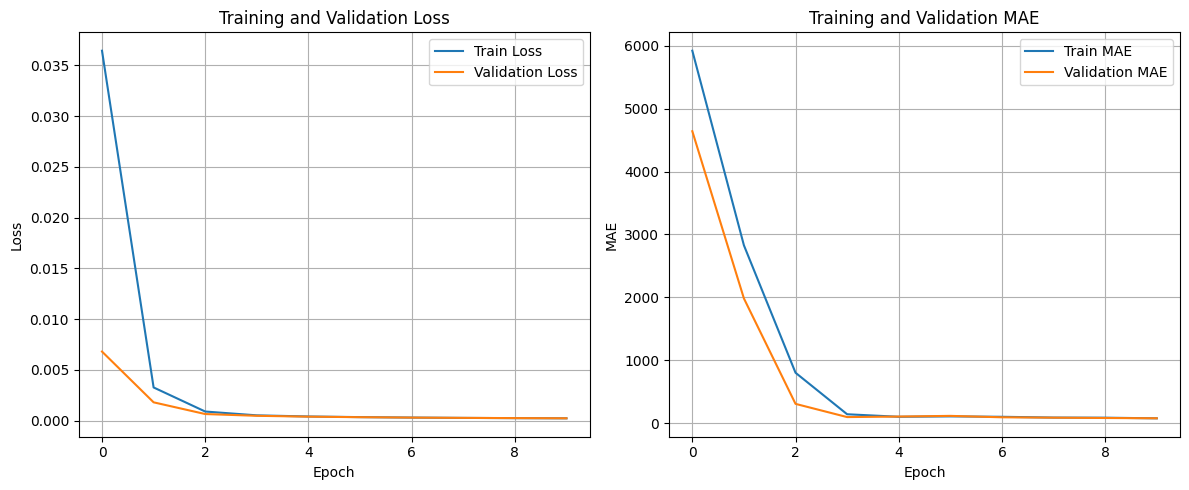


Starting evaluation on test set...


Testing: 100%|██████████| 20/20 [06:12<00:00, 18.62s/it]


Test Results:
MAE: 73.8225
MSE: 10445.7630
RMSE: 102.2045
Final Test MAE: 73.8225
Final Test MSE: 10445.7630
Final Test RMSE: 102.2045


In [1]:
from IPython import get_ipython
from IPython.display import display
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io
import scipy.ndimage as ndimage
from scipy.ndimage import gaussian_filter
import random
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# %%
class CrowdDataset(Dataset):
    def __init__(self, image_paths, ground_truth_paths, transform=None, augment=False, patch_size=256):
        self.image_paths = image_paths
        self.ground_truth_paths = ground_truth_paths
        self.transform = transform
        self.augment = augment
        self.patch_size = patch_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Initialize points and actual_count
        points = []
        actual_count = 0.0

        # Load ground truth from .mat file
        gt_path = self.ground_truth_paths[idx]
        try:
            mat_data = scipy.io.loadmat(gt_path)
            
            # Extract point coordinates from image_info[0,0][0,0][0] for density map generation
            extracted_points = mat_data['image_info'][0, 0][0, 0][0]
            if extracted_points.size > 0 and len(extracted_points.shape) == 2 and extracted_points.shape[1] == 2:
                points = extracted_points.tolist()
            else:
                points = []

            # Extract actual count directly from image_info[0,0][0,0][1]
            # Ensure the count data is numeric and can be converted to a float
            raw_count = mat_data['image_info'][0, 0][0, 0][1]
            actual_count = float(raw_count)

        except Exception as e:
            print(f"Error loading ground truth file {gt_path}: {e}. Defaulting to 0 points and 0 count.")
            points = []
            actual_count = 0.0

        # Generate density map from points
        # The density map is still generated even if actual_count comes from elsewhere,
        # as it's used for the regression branch.
        density_map = self.generate_density_map(img.shape[:2], points)

        # Apply augmentation if specified
        if self.augment:
            img, density_map = self.apply_augmentation(img, density_map)

        # Resize to patch size
        img = cv2.resize(img, (self.patch_size, self.patch_size))
        
        # --- IMPORTANT FIX: Re-normalize density map after resizing ---
        # Store original sum for scaling
        original_density_sum = np.sum(density_map)
        
        # Resize density map
        density_map = cv2.resize(density_map, (self.patch_size, self.patch_size), interpolation=cv2.INTER_LINEAR)
        
        # If the original density map had points, re-scale the resized map to match the original sum
        if original_density_sum > 0:
            current_density_sum = np.sum(density_map)
            if current_density_sum > 0: # Avoid division by zero if current_density_sum is also 0 somehow
                density_map = density_map * (original_density_sum / current_density_sum)
        # --- END IMPORTANT FIX ---

        # Convert to tensor
        img = torch.from_numpy(img.transpose(2, 0, 1)).float() / 255.0
        # Unsqueeze(0) for channel dimension (1, H, W)
        density_map = torch.from_numpy(density_map).float().unsqueeze(0)

        # Apply transforms if any
        if self.transform:
            img = self.transform(img)

        # Return the image, density map, and the actual count for metrics
        return img, density_map, torch.tensor(actual_count, dtype=torch.float32)

    def generate_density_map(self, img_shape, points):
        """Generate density map from point annotations using adaptive Gaussian kernels"""
        h, w = img_shape
        density_map = np.zeros((h, w), dtype=np.float32)

        if len(points) == 0:
            return density_map

        # Convert points to numpy array
        points = np.array(points)

        # For each point, calculate adaptive sigma based on k-nearest neighbors
        for i, point in enumerate(points):
            x, y = int(point[0]), int(point[1])

            # Skip if point is outside image bounds
            if x < 0 or x >= w or y < 0 or y >= h:
                continue

            # Calculate distance to k nearest neighbors (k=3)
            if len(points) > 1:
                distances = np.sqrt(np.sum((points - point) ** 2, axis=1))
                distances = np.sort(distances)[1:]  # Exclude self (distance=0)

                # Use average of 3 nearest neighbors or all if less than 3
                k = min(3, len(distances))
                avg_distance = np.mean(distances[:k])

                # Adaptive sigma based on local density
                sigma = max(1.0, avg_distance / 3.0)
            else:
                sigma = 4.0  # Default sigma for single point

            # Create Gaussian kernel
            kernel_size = int(6 * sigma)
            if kernel_size % 2 == 0:
                kernel_size += 1

            # Generate 2D Gaussian
            gaussian = self.gaussian_2d(kernel_size, sigma)

            # Add to density map
            x_start = max(0, x - kernel_size // 2)
            x_end = min(w, x + kernel_size // 2 + 1)
            y_start = max(0, y - kernel_size // 2)
            y_end = min(h, y + kernel_size // 2 + 1)

            # Adjust Gaussian bounds
            g_x_start = max(0, kernel_size // 2 - x)
            g_x_end = g_x_start + (x_end - x_start)
            g_y_start = max(0, kernel_size // 2 - y)
            g_y_end = g_y_start + (y_end - y_start)

            density_map[y_start:y_end, x_start:x_end] += gaussian[g_y_start:g_y_end, g_x_start:g_x_end]
        
        # Ensure the sum of the density map corresponds to the number of points initially,
        # but the actual_count from .mat is the primary source for metrics.
        # This is important if `actual_count` doesn't strictly equal len(points)
        # or if `cv2.resize` changes the sum.

        return density_map

    def gaussian_2d(self, kernel_size, sigma):
        """Generate 2D Gaussian kernel"""
        kernel = np.zeros((kernel_size, kernel_size))
        center = kernel_size // 2

        for i in range(kernel_size):
            for j in range(kernel_size):
                x, y = i - center, j - center
                kernel[i, j] = np.exp(-(x**2 + y**2) / (2 * sigma**2))

        return kernel / np.sum(kernel) # Normalize to sum to 1

    def apply_augmentation(self, img, density_map):
        """Apply data augmentation"""
        # Random horizontal flip
        if random.random() > 0.5:
            img = cv2.flip(img, 1)
            density_map = cv2.flip(density_map, 1)

        # Random brightness adjustment
        if random.random() > 0.5:
            brightness_factor = random.uniform(0.8, 1.2)
            img = np.clip(img * brightness_factor, 0, 255).astype(np.uint8)

        # Random noise
        if random.random() > 0.7:
            noise = np.random.normal(0, 5, img.shape).astype(np.uint8)
            img = np.clip(img + noise, 0, 255).astype(np.uint8)

        return img, density_map

# %%
class CascadedCNN(nn.Module):
    """Simplified Cascaded CNN for Crowd Density Estimation (Regression Only)"""
    def __init__(self):
        super(CascadedCNN, self).__init__()

        # Shared front-end network
        self.shared_conv = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Tanh(),
            nn.MaxPool2d(2, stride=2),
        )

        # Density estimation branch
        self.density_conv = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.Tanh(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.Tanh(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
        )

        # Fusion layers (now directly processes density features, adjusted input channels)
        # This block can be seen as further processing the density features before upsampling
        self.fusion_conv = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # Input channels from density_conv output (32)
            nn.BatchNorm2d(64),
            nn.Tanh(),
        )

        # Upsampling layers
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1), # Upsample to 128x128
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1), # Upsample to 256x256
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.Conv2d(16, 1, kernel_size=1), # Final 1x1 convolution to get 1 channel density map
        )

    def forward(self, x):
        # Shared front-end
        shared_features = self.shared_conv(x)

        # Density estimation branch
        density_features = self.density_conv(shared_features)

        # Fusion (now directly processes density_features)
        fused_features = self.fusion_conv(density_features)

        # Upsampling
        density_map = self.upsample(fused_features)

        return density_map # Only return density map for regression

# %%
class CrowdCountingTrainer:
    def __init__(self, model, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.model = model.to(device)
        self.device = device
        self.density_criterion = nn.MSELoss() # Only MSE Loss for regression
        self.optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=50, gamma=0.5) # Ensure step_size < epochs

        # Training history (removed classification related lists)
        self.train_losses = []
        self.val_losses = []
        self.train_maes = []
        self.val_maes = []

    # Removed get_count_class method as classification is no longer part of the pipeline

    def train_epoch(self, train_loader):
        self.model.train()
        total_loss = 0
        total_mae = 0
        
        # DataLoader now yields image, density_map, and actual_count
        for batch_idx, (images, density_maps, actual_counts_from_gt) in enumerate(tqdm(train_loader, desc="Training")):
            images = images.to(self.device)
            density_maps = density_maps.to(self.device)
            actual_counts_from_gt = actual_counts_from_gt.to(self.device)

            self.optimizer.zero_grad()

            # Forward pass: model now only returns pred_density
            pred_density = self.model(images)
            pred_counts = torch.sum(pred_density, dim=(1, 2, 3)) # Sum of predicted density map for count

            # Calculate loss (only density loss)
            density_loss = self.density_criterion(pred_density, density_maps)
            total_loss_batch = density_loss # Total loss is just density loss

            # Backward pass
            total_loss_batch.backward()
            self.optimizer.step()

            # Calculate MAE using predicted counts vs. actual counts from GT file
            mae = torch.mean(torch.abs(pred_counts - actual_counts_from_gt))

            total_loss += total_loss_batch.item()
            total_mae += mae.item()

            # Print actual vs predicted counts for first few batches
            if batch_idx < 3: # Print for first 3 batches
                # Fix: .detach() before .cpu().numpy()
                print(f"  Batch {batch_idx+1} (Train): Actual Counts (GT from .mat): {actual_counts_from_gt.detach().cpu().numpy().round(2)}")
                print(f"  Batch {batch_idx+1} (Train): Predicted Counts (from density map): {pred_counts.detach().cpu().numpy().round(2)}")
            
        avg_loss = total_loss / len(train_loader)
        avg_mae = total_mae / len(train_loader)

        return avg_loss, avg_mae

    def validate_epoch(self, val_loader):
        self.model.eval()
        total_loss = 0
        total_mae = 0

        with torch.no_grad():
            # DataLoader now yields image, density_map, and actual_count
            for batch_idx, (images, density_maps, actual_counts_from_gt) in enumerate(tqdm(val_loader, desc="Validation")):
                images = images.to(self.device)
                density_maps = density_maps.to(self.device) # Not strictly needed for validation metrics, but consistent.
                actual_counts_from_gt = actual_counts_from_gt.to(self.device)

                # Forward pass
                pred_density = self.model(images)
                pred_counts = torch.sum(pred_density, dim=(1, 2, 3))

                # Calculate loss
                density_loss = self.density_criterion(pred_density, density_maps)
                total_loss_batch = density_loss

                # Calculate MAE
                mae = torch.mean(torch.abs(pred_counts - actual_counts_from_gt))

                total_loss += total_loss_batch.item()
                total_mae += mae.item()

                # Print actual vs predicted counts for first few batches
                if batch_idx < 3: # Print for first 3 batches
                    # Fix: .detach() before .cpu().numpy()
                    print(f"  Batch {batch_idx+1} (Val): Actual Counts (GT from .mat): {actual_counts_from_gt.detach().cpu().numpy().round(2)}")
                    print(f"  Batch {batch_idx+1} (Val): Predicted Counts (from density map): {pred_counts.detach().cpu().numpy().round(2)}")
                
        avg_loss = total_loss / len(val_loader)
        avg_mae = total_mae / len(val_loader)

        return avg_loss, avg_mae

    def train(self, train_loader, val_loader, epochs=100, save_path='best_model.pth'):
        best_val_mae = float('inf')

        self.train_losses = []
        self.val_losses = []
        self.train_maes = []
        self.val_maes = []

        for epoch in range(epochs):
            print(f"\nEpoch {epoch+1}/{epochs}")

            # Training
            train_loss, train_mae = self.train_epoch(train_loader)

            # Validation
            val_loss, val_mae = self.validate_epoch(val_loader)

            # Update learning rate
            self.scheduler.step()

            # Save best model based on MAE
            if val_mae < best_val_mae:
                best_val_mae = val_mae
                torch.save({
                    'epoch': epoch,
                    'model_state_dict': self.model.state_dict(),
                    'optimizer_state_dict': self.optimizer.state_dict(),
                    'val_mae': val_mae,
                }, save_path)
                print(f"New best model saved with MAE: {val_mae:.4f}")

            # Store history
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_maes.append(train_mae)
            self.val_maes.append(val_mae)

            print(f"Train Loss: {train_loss:.4f}, Train MAE: {train_mae:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}")
            print(f"Learning Rate: {self.optimizer.param_groups[0]['lr']:.6f}")

    def test(self, test_loader, model_path='best_model.pth'):
        """Test the model on test dataset"""
        # Load best model
        # Using map_location='cpu' ensures it works even if GPU is not available for testing
        checkpoint = torch.load(model_path, map_location=self.device) 
        self.model.load_state_dict(checkpoint['model_state_dict'])

        self.model.eval()
        total_mae = 0
        total_mse = 0
        all_predictions = []
        all_ground_truths = []

        with torch.no_grad():
            for images, density_maps, actual_counts_from_gt in tqdm(test_loader, desc="Testing"):
                images = images.to(self.device)
                # density_maps = density_maps.to(self.device) # Not strictly needed if only using actual_counts_from_gt for GT
                actual_counts_from_gt = actual_counts_from_gt.to(self.device)

                # Forward pass
                pred_density = self.model(images)

                # Calculate counts
                pred_counts = torch.sum(pred_density, dim=(1, 2, 3))

                # Store predictions
                all_predictions.extend(pred_counts.detach().cpu().numpy()) # Fix: .detach() added
                all_ground_truths.extend(actual_counts_from_gt.detach().cpu().numpy()) # Fix: .detach() added

                # Calculate errors using actual_counts_from_gt
                mae = torch.mean(torch.abs(pred_counts - actual_counts_from_gt))
                mse = torch.mean((pred_counts - actual_counts_from_gt) ** 2)

                total_mae += mae.item()
                total_mse += mse.item()

        avg_mae = total_mae / len(test_loader)
        avg_mse = total_mse / len(test_loader)
        
        print(f"\nTest Results:")
        print(f"MAE: {avg_mae:.4f}")
        print(f"MSE: {avg_mse:.4f}")
        print(f"RMSE: {np.sqrt(avg_mse):.4f}")

        return avg_mae, avg_mse, all_predictions, all_ground_truths

    def plot_training_history(self):
        """Plot training history (Loss and MAE only)"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5)) # Changed to 2 subplots

        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss')
        ax1.plot(self.val_losses, label='Validation Loss')
        ax1.set_title('Training and Validation Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Plot MAE
        ax2.plot(self.train_maes, label='Train MAE')
        ax2.plot(self.val_maes, label='Validation MAE')
        ax2.set_title('Training and Validation MAE')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('MAE')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

# %%
def load_data_paths(train_images_dir, train_gt_dir, test_images_dir, test_gt_dir):
    """Load image and ground truth file paths"""

    # Get training data paths
    train_img_paths = []
    train_gt_paths = []

    if not os.path.exists(train_images_dir):
        print(f"Warning: Training images directory not found: {train_images_dir}")
    if not os.path.exists(train_gt_dir):
        print(f"Warning: Training GT directory not found: {train_gt_dir}")

    for img_file in os.listdir(train_images_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(train_images_dir, img_file)
            # Assuming ground truth files have same name but with .mat extension
            gt_file = 'GT_' + os.path.splitext(img_file)[0] + '.mat'
            gt_path = os.path.join(train_gt_dir, gt_file)

            if os.path.exists(gt_path):
                train_img_paths.append(img_path)
                train_gt_paths.append(gt_path)
            else:
                print(f"Warning: Corresponding GT file not found for {img_file} at {gt_path}")


    # Get test data paths
    test_img_paths = []
    test_gt_paths = []

    if not os.path.exists(test_images_dir):
        print(f"Warning: Test images directory not found: {test_images_dir}")
    if not os.path.exists(test_gt_dir):
        print(f"Warning: Test GT directory not found: {test_gt_dir}")

    for img_file in os.listdir(test_images_dir):
        if img_file.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_path = os.path.join(test_images_dir, img_file)
            gt_file = 'GT_' + os.path.splitext(img_file)[0] + '.mat'
            gt_path = os.path.join(test_gt_dir, gt_file)

            if os.path.exists(gt_path):
                test_img_paths.append(img_path)
                test_gt_paths.append(gt_path)
            else:
                print(f"Warning: Corresponding GT file not found for {img_file} at {gt_path}")

    return train_img_paths, train_gt_paths, test_img_paths, test_gt_paths

# %%
def main():
    """Main function to run the complete pipeline for density regression"""

    # Configuration
    config = {
        'train_images_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/train_data/images',  # UPDATE THIS PATH
        'train_gt_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/train_data/ground_truth',  # UPDATE THIS PATH
        'test_images_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/test_data/images',  # UPDATE THIS PATH
        'test_gt_dir': '/kaggle/input/crowd-wala/crowd_wala_dataset/test_data/ground_truth',  # UPDATE THIS PATH
        'batch_size': 16,
        'epochs': 10, # Adjusted epochs. Ensure step_size in scheduler is set appropriately, e.g., 10 or 15.
        'patch_size': 256,
        'val_split': 0.2,
        'num_workers': 4,
        'save_path': 'cascaded_cnn_regression_only.pth', # Updated save path name
    }

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    print("Loading data paths...")
    train_img_paths, train_gt_paths, test_img_paths, test_gt_paths = load_data_paths(
        config['train_images_dir'],
        config['train_gt_dir'],
        config['test_images_dir'],
        config['test_gt_dir']
    )

    print(f"Found {len(train_img_paths)} training images with GT")
    print(f"Found {len(test_img_paths)} test images with GT")

    if not train_img_paths:
        print("Error: No training images with corresponding ground truth found. Please check your data paths and file naming conventions.")
        return

    # Split training data into train and validation
    # No stratification needed as classification is removed
    train_imgs, val_imgs, train_gts, val_gts = train_test_split(
        train_img_paths, train_gt_paths,
        test_size=config['val_split'],
        random_state=42
    )

    print(f"Train set: {len(train_imgs)} images")
    print(f"Validation set: {len(val_imgs)} images")

    # Create datasets
    train_dataset = CrowdDataset(
        train_imgs, train_gts,
        augment=True,
        patch_size=config['patch_size']
    )

    val_dataset = CrowdDataset(
        val_imgs, val_gts,
        augment=False,
        patch_size=config['patch_size']
    )

    test_dataset = CrowdDataset(
        test_img_paths, test_gt_paths,
        augment=False,
        patch_size=config['patch_size']
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=config['batch_size'],
        shuffle=True,
        num_workers=config['num_workers']
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers']
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=config['batch_size'],
        shuffle=False,
        num_workers=config['num_workers']
    )

    # Initialize model and trainer
    model = CascadedCNN() # num_classes is no longer passed
    model.to(device)
    trainer = CrowdCountingTrainer(model) # No num_classes for trainer

    print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")

    # Train the model
    print("Starting training...")
    trainer.train(
        train_loader,
        val_loader,
        epochs=config['epochs'],
        save_path=config['save_path']
    )

    # Plot training history
    trainer.plot_training_history()

    # Test the model
    if test_img_paths:
        print("\nStarting evaluation on test set...")
        test_mae, test_mse, all_predictions, all_ground_truths = trainer.test(
            test_loader,
            model_path=config['save_path']
        )
        print(f"Final Test MAE: {test_mae:.4f}")
        print(f"Final Test MSE: {test_mse:.4f}")
        print(f"Final Test RMSE: {np.sqrt(test_mse):.4f}")
    else:
        print("No test data found for evaluation.")

# %%
if __name__ == "__main__":
    main()